In [1]:
%%capture
!pip install fastparquet
!pip install pandarallel

In [2]:
import pystan
import numpy as np
import pandas as pd
import pickle
from src.utils import create_output_directories
import seaborn as sns
#Set up parallel processing
from pandarallel import pandarallel
from tqdm.notebook import trange, tqdm
from src.tables import get_table
import os
os.environ["TMPDIR"] = "/home/joebak/tmp"

pandarallel.initialize(nb_workers=8,verbose=True,progress_bar=True)
tqdm.pandas()

#Make sure things reload
%load_ext autoreload
%autoreload 2

root = '.'
pal = sns.color_palette("Set2",n_colors=8)

create_output_directories()

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


<h1>Overview</h1>

Below is the code necessary to recreate the analysis from "Combining interventions to reduce the spread of viral misinformation." This notebook assumes that there is a folder located in "root" (default '.') called "data" containing:
<ol>
<li>Directory: Timeseries with subdirectories:</li>
    <ul>
    <li>aggressive</li>
    <li>modest</li>
    <li>currently</li>
    <li>Verified</li>
    <li>500k, 100k, 50k, 10k</li>
    <li>aggregated</li>
    <li>raw</li>
     </ul>
<li>ban_df_counts.parquet</li>
<li>events.parquet</li>
<li>incidents.parquet</li>
</ol>

Each of the subdirectories should contain aggregated time-series data, downloaded from LINK for each of the unfiltered events. This data were generated from our raw data which is not shared for privacy concerns. However, we include the code used to generate the aggregated time-series for application to novel datasets.


<h1>Segmentation and model fit</h1>

<h2>Segmentation</h2>

We begin by segmenting the time series of incidents into distinct events. Here, we define events as periods of heightened activity. Boundaries between events occur when the volume of tweets follows below 5% of the maximum 5-minute post volume for that event  (paramters before_min, after_min in srcseg.get_peaks). Events within an incident are included if their peak height is at least 30% of the maximum peak height across the entire incident (parameter pmin for srseg.get_peaks). 

In [3]:
incidents = pd.read_csv('./data/incidents.csv')

In [4]:
import src.segmentation as srcseg

def event_df(row):
    peaks = srcseg.get_peaks(row,root='.',start=0, freq=5,pmin=.3,
                      after_min=.05, before_min=.05)
    event_dictionaries = []
    for idx, peak in enumerate(peaks):
        one_event = {'incident_name':row['incident_name'],
                     'start':peak[0],
                     'end':peak[1],
                     'event_name':row['incident_name']+'_event_'+str(idx)}
        event_dictionaries.append(one_event)
    return pd.DataFrame(event_dictionaries)


events = pd.concat([pd.DataFrame(item) for item in incidents.T.parallel_apply(event_df,
                                                                     result_type='reduce')])
events = pd.merge(events, incidents, left_on='incident_name', right_on='incident_name')
events = events[(events['end'] - events['start']) >=12]
events.to_csv(root + '/data/events.csv',compression=None)
print('Found %s events' % str(events.shape[0]))
_ = events.T.parallel_apply(srcseg.plot_event)

Found 600 events


<h2> Fit model to all events </h2>

With events segmented, we turn to evaluating our model fit with regards to each event. Our model, in its simplest form  can be described as: 

\begin{equation}
\label{eq1}
\begin{aligned}
    y_{t} &=  \exp(\alpha + \beta v_{t-1})\\
    v_{t} &= v_{t-1} \delta e^{-\lambda t} + x[t] \\
    x_{t} &= \log(\sum_{j=1}^{y_t} F_{j})
\end{aligned}
\end{equation}

Where $y_t$ are the tweets at time $t$, $\alpha$ is the baseline rate of discussion, and $\beta$ is the effect of virality, $v$. Virality decays exponentially as a function of $\delta$ and $\lambda$. Here, $\delta$ captures the baseline rate of decay per time step, and $\lambda$ controls the way in which that decay changes over the lifetime of an event. This could either be due to algorithmic processes favoring new content or, for very large events, user saturation. Every time step, for each of $y_t$ accounts, the log sum ($x_t$) of their followers, $F_j$ is added to virality for the subsequent time step. We translate this into a bayesian statistical model such that: 

\begin{align*}
y_{t} &\sim \text{NegativeBinomial2}(\mu_{t}, \phi) \text{ for }t=2...T \\ 
\mu_{i} &= \exp(\alpha + \beta v_{t-1})\text{ for  }t=2...T \\ 
v_{t} &= v_{t-1}\delta e^{-\lambda t} + x_{t} \\
\alpha &\sim \text{Normal}(-3,3) \\
\beta &\sim \text{Normal}(0,3) \\
\delta &\sim \text{Beta}(2,2) \\
\lambda &\sim \text{HalfExponential}(1) \\
\phi &\sim \text{HalfExponential}(1) \\ 
v_{1} &= x_{1}\\
x_{t} &= \log(\sum_{j=1}^{y_t} F_{j}+1)
\end{align*}

This model can be found in /src/timeseries.stan. Because our model makes assumptions about how misinformation cascades spread, it is unlikely to fit everything that is considered an event. Ways in which we can identify a failed fit include parameters not converging, divergent transitions, or the posterior predictive distribution of cascade sizes not containing observed value. Here, we load the model and apply it to each segmented event. We then evaluate inclusion criteria and plot all successfully fitted events for visual inspection. Note that Stan will (and should) yell at us when events fail to fit. This is expected at this stage. 


In [5]:
events = pd.read_csv(root + '/data/events.csv')

In [6]:
#Compile model, we only need to do this once. 
model = pystan.StanModel(root + '/src/timeseries.stan')
pickle.dump(model, open(root + '/output/posteriors/model.p','wb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e9b01ffa7f928081550461f3ea02ee79 NOW.
In file included from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1969,
                 from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /tmp/pystan_aalo0e1b/stanfit4anon_model_e9b01ffa7f928081550461f3ea02ee79_613057193531111528.cpp:709:
/opt/conda/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
In file included from /opt/conda/lib/python3.9/site-packages/pystan/stan/lib/stan_math/stan/math/prim/mat/prob/poisson_log_glm_log.hpp:5,
                 from /opt

In [7]:
model = pickle.load(open(root + '/output/posteriors/model.p','rb'))

In [8]:
events['duration'] = events['end'] - events['start']
events.sort_values('duration',inplace=True)

In [ ]:
#Fit model to all events, save them. 
#This will take a while
#We will get some divergent transitions,warnings
#But we're not expecting our model to fit every time series
#That's 
import src.model_fit as srcmf
diagnostics = []
for idx in tqdm(range(events.shape[0])):
    diagnostics.append(srcmf.fit_model(events.iloc[idx],model,keep=True))

  0%|          | 0/600 [00:00<?, ?it/s]



Gradient evaluation took 3.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.476933 seconds (Warm-up)
               0.252767 seconds (Sampling)
               0.7297 seconds (Total)


 Elapsed Time: 0.906947 seconds (Warm-up)
               0.367958 seconds (Sampling)
               1.2749 seconds (Total)


 Elapsed Time: 0.798986 seconds (Warm-up)
               0.601023 seconds (Sampling)
               1.40001 seconds (Total)


 Elapsed Time: 0.773122 seconds (Warm-up)
               0.934437 seconds (Sampling)
               1.70756 seconds (Total)



/home/joebak/Projects/CombinedPolicy/src/model_fit.py:29: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(samples,



Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.8 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 6e-05 seconds
Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.374668 seconds (Warm-up)
               0.171826 seconds (Sampling)
               0.546494 seconds (Total)


 Elapsed Time: 0.426623 seconds (Warm-up)
               0.348646 seconds (Sampling)
               0.775269 seconds (Total)


 Elapsed Time: 0.597187 seconds (Warm-up)
               0.348784 seconds (Sampling)
               0.945971 seconds (Total)


 Elapsed Time: 0.70609 seconds (Warm-up)
               0.483419 seconds (Sampling)
               1.18951 seconds (Total)


Gradient evaluation took 2.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!



Grad

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.704583 seconds (Warm-up)
               0.409434 seconds (Sampling)
               1.11402 seconds (Total)


 Elapsed Time: 1.24589 seconds (Warm-up)
               0.53091 seconds (Sampling)
               1.7768 seconds (Total)


 Elapsed Time: 1.40705 seconds (Warm-up)
               0.56043 seconds (Sampling)
               1.96748 seconds (Total)


 Elapsed Time: 1.3804 seconds (Warm-up)
               0.798741 seconds (Sampling)
               2.17914 seconds (Total)



Gradient evaluation took 2.9e-05 seconds
Gradient evaluation took 3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Adjust your expectations accordingly!



Gradient evaluation

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 0.629126 seconds (Warm-up)
               0.313329 seconds (Sampling)
               0.942455 seconds (Total)


 Elapsed Time: 0.69294 seconds (Warm-up)
               0.266803 seconds (Sampling)
               0.959743 seconds (Total)


 Elapsed Time: 0.712625 seconds (Warm-up)
               0.431688 seconds (Sampling)
               1.14431 seconds (Total)


 Elapsed Time: 0.882416 seconds (Warm-up)
               0.534394 seconds (Sampling)
               1.41681 seconds (Total)


Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 0.419096 seconds (Warm-up)
               0.200521 seconds (Sampling)
               0.619617 seconds (Total)


 Elapsed Time: 0.519963 seconds (Warm-up)
               0.524163 seconds (Sampling)
               1.04413 seconds (Total)


 Elapsed Time: 0.563137 seconds (Warm-up)
               0.48805 seconds (Sampling)
               1.05119 seconds (Total)


 Elapsed Time: 0.751142 seconds (Warm-up)
               0.361549 seconds (Sampling)
               1.11269 seconds (Total)



Gradient evaluation took 4.5e-05 seconds
Gradient evaluation took 4.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!
1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.


Adjust your expectations accordingly!



Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Gradie

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.535628 seconds (Warm-up)
               0.236553 seconds (Sampling)
               0.772181 seconds (Total)


 Elapsed Time: 0.621559 seconds (Warm-up)
               0.386014 seconds (Sampling)
               1.00757 seconds (Total)


 Elapsed Time: 0.766017 seconds (Warm-up)
               0.32419 seconds (Sampling)
               1.09021 seconds (Total)


 Elapsed Time: 0.877423 seconds (Warm-up)
               0.295439 seconds (Sampling)
               1.17286 seconds (Total)



Gradient evaluation took 4.4e-05 seconds
Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!



Gradie

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.78748 seconds (Warm-up)
               0.886823 seconds (Sampling)
               2.6743 seconds (Total)


 Elapsed Time: 2.02263 seconds (Warm-up)
               0.861066 seconds (Sampling)
               2.8837 seconds (Total)


 Elapsed Time: 1.15107 seconds (Warm-up)
               1.74422 seconds (Sampling)
               2.89529 seconds (Total)


 Elapsed Time: 2.00283 seconds (Warm-up)
               0.900066 seconds (Sampling)
               2.90289 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 3.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.431892 seconds (Warm-up)
               0.222205 seconds (Sampling)
               0.654097 seconds (Total)


 Elapsed Time: 0.603488 seconds (Warm-up)
               0.231063 seconds (Sampling)
               0.834551 seconds (Total)


 Elapsed Time: 0.541311 seconds (Warm-up)
               0.313124 seconds (Sampling)
        

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.84738 seconds (Warm-up)
               0.457691 seconds (Sampling)
               1.30507 seconds (Total)


 Elapsed Time: 1.15134 seconds (Warm-up)
               0.516952 seconds (Sampling)
               1.66829 seconds (Total)


 Elapsed Time: 1.7497 seconds (Warm-up)
               0.518127 seconds (Sampling)
               2.26782 seconds (Total)


 Elapsed Time: 1.4882 seconds (Warm-up)
               1.3804 seconds (Sampling)
               2.86859 seconds (Total)


Gradient evaluation took 3.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient evaluati

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.314057 seconds (Warm-up)
               0.141922 seconds (Sampling)
               0.455979 seconds (Total)


 Elapsed Time: 0.392876 seconds (Warm-up)
               0.296224 seconds (Sampling)
               0.6891 seconds (Total)


 Elapsed Time: 0.601972 seconds (Warm-up)
               0.250805 seconds (Sampling)
               0.852777 seconds (Total)


 Elapsed Time: 0.660456 seconds (Warm-up)
               0.261082 seconds (Sampling)
               0.921538 seconds (Total)


Gradient evaluation took 2.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!



Grad

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.660936 seconds (Warm-up)
               0.164864 seconds (Sampling)
               0.8258 seconds (Total)


 Elapsed Time: 0.53177 seconds (Warm-up)
               0.408448 seconds (Sampling)
               0.940218 seconds (Total)


 Elapsed Time: 0.82382 seconds (Warm-up)
               0.178449 seconds (Sampling)
               1.00227 seconds (Total)




 Elapsed Time: 0.69439 seconds (Warm-up)
               0.660344 seconds (Sampling)
               1.35473 seconds (Total)


Gradient evaluation took 2.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.430679 seconds (Warm-up)
               0.240139 seconds (Sampling)
               0.670818 seconds (Total)


 Elapsed Time: 0.561757 seconds (Warm-up)
               0.23537 seconds (Sampling)
               0.797127 seconds (Total)


 Elapsed Time: 0.73377 seconds (Warm-up)
               0.268923 seconds (Sampling)
               1.00269 seconds (Total)


 Elapsed Time: 0.583023 seconds (Warm-up)
               0.438168 seconds (Sampling)
               1.02119 seconds (Total)



Gradient evaluation took 4.5e-05 seconds
Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Adjust your expectations accordingly!



Gradie

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.397829 seconds (Warm-up)
               0.21 seconds (Sampling)
               0.607829 seconds (Total)


 Elapsed Time: 0.689896 seconds (Warm-up)
               0.30489 seconds (Sampling)
               0.994786 seconds (Total)


 Elapsed Time: 0.745036 seconds (Warm-up)
               0.319553 seconds (Sampling)
               1.06459 seconds (Total)


 Elapsed Time: 0.901291 seconds (Warm-up)
               0.341064 seconds (Sampling)
               1.24235 seconds (Total)


Gradient evaluation took 4.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 5.5e-05 seconds
Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.494361 seconds (Warm-up)
               0.213268 seconds (Sampling)
               0.707629 seconds (Total)


 Elapsed Time: 0.509421 seconds (Warm-up)
               0.303737 seconds (Sampling)
               0.813158 seconds (Total)


 Elapsed Time: 0.698514 seconds (Warm-up)
               0.471267 seconds (Sampling)
               1.16978 seconds (Total)


 Elapsed Time: 0.703672 seconds (Warm-up)
               0.546059 seconds (Sampling)
               1.24973 seconds (Total)



Gradient evaluation took 3.9e-05 seconds
Gradient evaluation took 3.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!



Grad

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


Gradient evaluation took 4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.2e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 4.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.549319 seconds (Warm-up)
               0.258809 seconds (Sampling)
               0.808128 seconds (Total)


 Elapsed Time: 0.967444 seconds (Warm-up)
               0.331055 seconds (Sampling)
               1.2985 seconds (Total)


 Elapsed Time: 1.08552 seconds (Warm-up)
               0.371285 seconds (Sampling)
              

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.519559 seconds (Warm-up)
               0.206817 seconds (Sampling)
               0.726376 seconds (Total)


 Elapsed Time: 0.648205 seconds (Warm-up)
               0.346576 seconds (Sampling)
               0.994781 seconds (Total)


 Elapsed Time: 0.979197 seconds (Warm-up)
               0.356812 seconds (Sampling)
               1.33601 seconds (Total)


 Elapsed Time: 0.928915 seconds (Warm-up)
               0.433063 seconds (Sampling)
               1.36198 seconds (Total)


Gradient evaluation took 4.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!



Grad

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.846407 seconds (Warm-up)
               0.36094 seconds (Sampling)
               1.20735 seconds (Total)


 Elapsed Time: 1.03966 seconds (Warm-up)
               0.399069 seconds (Sampling)
               1.43873 seconds (Total)


 Elapsed Time: 1.00708 seconds (Warm-up)
               0.477615 seconds (Sampling)
               1.48469 seconds (Total)


 Elapsed Time: 0.957158 seconds (Warm-up)
               0.646855 seconds (Sampling)
               1.60401 seconds (Total)


Gradient evaluation took 4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.4e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!
Gradient evaluation took 3.9e-05 seconds


1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!



Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.29279 seconds (Warm-up)
               0.196048 seconds (Sampling)
               0.488838 seconds (Total)


 Elapsed Time: 0.629034 seconds (Warm-up)
               0.135751 seconds (Sampling)
               0.764785 seconds (Total)


 Elapsed Time: 0.754716 seconds (Warm-up)
               0.266484 seconds (Sampling)
               1.0212 seconds (Total)


 Elapsed Time: 0.892043 seconds (Warm-up)
               0.246403 seconds (Sampling)
               1.13845 seconds (Total)




Gradient evaluation took 3.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.2e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 3.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.352821 seconds (Warm-up)
               0.225525 seconds (Sampling)
               0.578346 seconds (Total)


 Elapsed Time: 0.525742 seconds (Warm-up)
               0.276778 seconds (Sampling)
               0.80252 seconds (Total)


 Elapsed Time: 0.657303 seconds (Warm-up)
               0.31852 seconds (Sampling)
               0.975823 seconds (Total)


 Elapsed Time: 0.669414 seconds (Warm-up)
               0.632333 seconds (Sampling)
               1.30175 seconds (Total)




Gradient evaluation took 3.9e-05 seconds
Gradient evaluation took 4e-05 seconds
Gradient evaluation took 3.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!




1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.462509 seconds (Warm-up)
               0.226341 seconds (Sampling)
               0.68885 seconds (Total)


 Elapsed Time: 0.499741 seconds (Warm-up)
               0.409245 seconds (Sampling)
               0.908986 seconds (Total)


 Elapsed Time: 0.75045 seconds (Warm-up)
               0.338249 seconds (Sampling)
               1.0887 seconds (Total)


 Elapsed Time: 1.07071 seconds (Warm-up)
               0.55857 seconds (Sampling)
               1.62928 seconds (Total)


Gradient evaluation took 3.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Adjust your expectations accordingly!



Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.741738 seconds (Warm-up)
               0.386383 seconds (Sampling)
               1.12812 seconds (Total)


 Elapsed Time: 0.89155 seconds (Warm-up)
               0.320785 seconds (Sampling)
               1.21233 seconds (Total)


 Elapsed Time: 0.747795 seconds (Warm-up)
               0.476478 seconds (Sampling)
               1.22427 seconds (Total)


 Elapsed Time: 0.802265 seconds (Warm-up)
               0.474948 seconds (Sampling)
               1.27721 seconds (Total)


Gradient evaluation took 3.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Adjust your expectations accordingly!



Gradien

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.374887 seconds (Warm-up)
               0.179438 seconds (Sampling)
               0.554325 seconds (Total)


 Elapsed Time: 0.630025 seconds (Warm-up)
               0.338408 seconds (Sampling)
               0.968433 seconds (Total)


 Elapsed Time: 0.723659 seconds (Warm-up)
               0.301258 seconds (Sampling)
               1.02492 seconds (Total)


 Elapsed Time: 0.701248 seconds (Warm-up)
               0.451585 seconds (Sampling)
               1.15283 seconds (Total)


Gradient evaluation took 3.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
Adjust your expectations accordingly!





Gradient evaluation took 3.7e-05 seconds
Gradient evaluation took 3.6e-05 seconds
Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
1000 transitions using 10 leapfrog steps pe

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.376062 seconds (Warm-up)
               0.245194 seconds (Sampling)
               0.621256 seconds (Total)


 Elapsed Time: 0.436125 seconds (Warm-up)
               0.18881 seconds (Sampling)
               0.624935 seconds (Total)


 Elapsed Time: 0.392725 seconds (Warm-up)
               0.266982 seconds (Sampling)
               0.659707 seconds (Total)


 Elapsed Time: 0.429208 seconds (Warm-up)
               0.308431 seconds (Sampling)
               0.737639 seconds (Total)


Gradient evaluation took 2.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 4.1e-05 seconds
Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Ad

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.635923 seconds (Warm-up)
               0.169033 seconds (Sampling)
               0.804956 seconds (Total)


 Elapsed Time: 0.674711 seconds (Warm-up)
               0.293723 seconds (Sampling)
               0.968434 seconds (Total)


 Elapsed Time: 0.718463 seconds (Warm-up)
               0.258244 seconds (Sampling)
               0.976707 seconds (Total)




 Elapsed Time: 1.01731 seconds (Warm-up)
               0.287677 seconds (Sampling)
               1.30499 seconds (Total)


Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 3.9e-05 seconds
Gradient evaluation took 4.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.556687 seconds (Warm-up)
               0.167293 seconds (Sampling)
               0.72398 seconds (Total)


 Elapsed Time: 0.686959 seconds (Warm-up)
               0.425194 seconds (Sampling)
               1.11215 seconds (Total)


 Elapsed Time: 1.00852 seconds (Warm-up)
               0.202909 seconds (Sampling)
               1.21142 seconds (Total)




 Elapsed Time: 0.923325 seconds (Warm-up)
               1.12004 seconds (Sampling)
               2.04336 seconds (Total)


Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.502744 seconds (Warm-up)
               0.152454 seconds (Sampling)
               0.655198 seconds (Total)


 Elapsed Time: 0.614307 seconds (Warm-up)
               0.260277 seconds (Sampling)
               0.874584 seconds (Total)


 Elapsed Time: 0.833357 seconds (Warm-up)
               0.141622 seconds (Sampling)
               0.974979 seconds (Total)


 Elapsed Time: 0.443368 seconds (Warm-up)
               0.627688 seconds (Sampling)
               1.07106 seconds (Total)


Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!



Gradie

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.77022 seconds (Warm-up)
               0.27588 seconds (Sampling)
               1.0461 seconds (Total)


 Elapsed Time: 0.774455 seconds (Warm-up)
               0.37028 seconds (Sampling)
               1.14474 seconds (Total)


 Elapsed Time: 0.762883 seconds (Warm-up)
               0.445548 seconds (Sampling)
               1.20843 seconds (Total)


 Elapsed Time: 0.85396 seconds (Warm-up)
               0.403531 seconds (Sampling)
               1.25749 seconds (Total)


Gradient evaluation took 4.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.9e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 4.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
Adjust your expectations accordingly!



Gradient ev

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.600499 seconds (Warm-up)
               0.211852 seconds (Sampling)
               0.812351 seconds (Total)


 Elapsed Time: 0.637855 seconds (Warm-up)
               0.353941 seconds (Sampling)
               0.991796 seconds (Total)




 Elapsed Time: 0.970202 seconds (Warm-up)
               0.291076 seconds (Sampling)
               1.26128 seconds (Total)


 Elapsed Time: 0.675321 seconds (Warm-up)
               0.617331 seconds (Sampling)
               1.29265 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 4.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.8e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.775459 seconds (Warm-up)
               0.519923 seconds (Sampling)
               1.29538 seconds (Total)


 Elapsed Time: 0.880975 seconds (Warm-up)
               0.480826 seconds (Sampling)
               1.3618 seconds (Total)


 Elapsed Time: 1.02388 seconds (Warm-up)
               0.545164 seconds (Sampling)
            

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either


 Elapsed Time: 0.619699 seconds (Warm-up)
               0.366092 seconds (Sampling)
               0.985791 seconds (Total)


 Elapsed Time: 0.732007 seconds (Warm-up)
               0.348966 seconds (Sampling)
               1.08097 seconds (Total)


 Elapsed Time: 0.827786 seconds (Warm-up)
               0.343212 seconds (Sampling)
               1.171 seconds (Total)


 Elapsed Time: 0.783906 seconds (Warm-up)
               0.657496 seconds (Sampling)
               1.4414 seconds (Total)


Gradient evaluation took 4.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.6e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 4.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, 


 Elapsed Time: 0.482619 seconds (Warm-up)
               0.29049 seconds (Sampling)
               0.773109 seconds (Total)


 Elapsed Time: 1.01928 seconds (Warm-up)
               0.492672 seconds (Sampling)
               1.51196 seconds (Total)


 Elapsed Time: 0.900642 seconds (Warm-up)
               0.701287 seconds (Sampling)
               1.60193 seconds (Total)


 Elapsed Time: 1.20187 seconds (Warm-up)
               0.405842 seconds (Sampling)
               1.60772 seconds (Total)


Gradient evaluation took 3.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!



Gradient ev

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.396606 seconds (Warm-up)
               0.230893 seconds (Sampling)
               0.627499 seconds (Total)


 Elapsed Time: 0.810451 seconds (Warm-up)
               0.360326 seconds (Sampling)
               1.17078 seconds (Total)


 Elapsed Time: 0.867728 seconds (Warm-up)
               0.375876 seconds (Sampling)
               1.2436 seconds (Total)


 Elapsed Time: 0.964939 seconds (Warm-up)
               0.438384 seconds (Sampling)
               1.40332 seconds (Total)


Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!



Gradie

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.862167 seconds (Warm-up)
               0.491862 seconds (Sampling)
               1.35403 seconds (Total)


 Elapsed Time: 1.21303 seconds (Warm-up)
               0.669695 seconds (Sampling)
               1.88272 seconds (Total)


 Elapsed Time: 1.40048 seconds (Warm-up)
               0.80251 seconds (Sampling)
               2.20299 seconds (Total)


 Elapsed Time: 1.33978 seconds (Warm-up)
               1.04859 seconds (Sampling)
               2.38837 seconds (Total)


Gradient evaluation took 4.2e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 4.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Adjust your expectations accordingly!



Gradient evalu

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.753442 seconds (Warm-up)
               0.458842 seconds (Sampling)
               1.21228 seconds (Total)


 Elapsed Time: 0.804701 seconds (Warm-up)
               0.59563 seconds (Sampling)
               1.40033 seconds (Total)


 Elapsed Time: 1.16129 seconds (Warm-up)
               0.377389 seconds (Sampling)
               1.53868 seconds (Total)


 Elapsed Time: 1.30396 seconds (Warm-up)
               0.749621 seconds (Sampling)
               2.05358 seconds (Total)



Gradient evaluation took 4.3e-05 seconds
Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.319894 seconds (Warm-up)
               0.192677 seconds (Sampling)
               0.512571 seconds (Total)


 Elapsed Time: 0.508079 seconds (Warm-up)
               0.266599 seconds (Sampling)
               0.774678 seconds (Total)


 Elapsed Time: 0.551607 seconds (Warm-up)
               0.270224 seconds (Sampling)
               0.821831 seconds (Total)


 Elapsed Time: 0.726154 seconds (Warm-up)
               1.56666 seconds (Sampling)
               2.29281 seconds (Total)


Gradient evaluation took 4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!



Gradient e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.06887 seconds (Warm-up)
               0.37468 seconds (Sampling)
               1.44355 seconds (Total)


 Elapsed Time: 0.808878 seconds (Warm-up)
               0.839214 seconds (Sampling)
               1.64809 seconds (Total)


 Elapsed Time: 1.0899 seconds (Warm-up)
               0.616457 seconds (Sampling)
               1.70636 seconds (Total)


 Elapsed Time: 1.13779 seconds (Warm-up)
               0.695038 seconds (Sampling)
               1.83283 seconds (Total)



Gradient evaluation took 4e-05 seconds
Gradient evaluation took 4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluati

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.560023 seconds (Warm-up)
               0.264135 seconds (Sampling)
               0.824158 seconds (Total)


 Elapsed Time: 0.486171 seconds (Warm-up)
               0.576867 seconds (Sampling)
               1.06304 seconds (Total)


 Elapsed Time: 0.671526 seconds (Warm-up)
               0.84993 seconds (Sampling)
               1.52146 seconds (Total)


 Elapsed Time: 1.09596 seconds (Warm-up)
               0.558546 seconds (Sampling)
               1.65451 seconds (Total)


Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!



Gradien

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.808945 seconds (Warm-up)
               0.333668 seconds (Sampling)
               1.14261 seconds (Total)


 Elapsed Time: 0.929667 seconds (Warm-up)
               0.326425 seconds (Sampling)
               1.25609 seconds (Total)


 Elapsed Time: 1.02741 seconds (Warm-up)
               0.577087 seconds (Sampling)
               1.6045 seconds (Total)


 Elapsed Time: 1.17603 seconds (Warm-up)
               0.729763 seconds (Sampling)
               1.90579 seconds (Total)


Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.518543 seconds (Warm-up)
               0.176072 seconds (Sampling)
               0.694615 seconds (Total)


 Elapsed Time: 0.512355 seconds (Warm-up)
               0.23233 seconds (Sampling)
               0.744685 seconds (Total)


 Elapsed Time: 0.729116 seconds (Warm-up)
               0.320527 seconds (Sampling)
               1.04964 seconds (Total)


 Elapsed Time: 1.09624 seconds (Warm-up)
               0.318935 seconds (Sampling)
               1.41518 seconds (Total)


Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.453137 seconds (Warm-up)
               0.218947 seconds (Sampling)
               0.672084 seconds (Total)


 Elapsed Time: 0.502858 seconds (Warm-up)
               0.216046 seconds (Sampling)
               0.718904 seconds (Total)


 Elapsed Time: 0.64773 seconds (Warm-up)
               0.302929 seconds (Sampling)
               0.950659 seconds (Total)


 Elapsed Time: 0.722879 seconds (Warm-up)
               0.428708 seconds (Sampling)
               1.15159 seconds (Total)


Gradient evaluation took 3.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!



Grad

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.789603 seconds (Warm-up)
               0.386633 seconds (Sampling)
               1.17624 seconds (Total)


 Elapsed Time: 0.991025 seconds (Warm-up)
               0.441459 seconds (Sampling)
               1.43248 seconds (Total)


 Elapsed Time: 0.93075 seconds (Warm-up)
               0.658683 seconds (Sampling)
               1.58943 seconds (Total)


 Elapsed Time: 0.963202 seconds (Warm-up)
               0.62963 seconds (Sampling)
               1.59283 seconds (Total)


Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!


Gradient evalu

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.35523 seconds (Warm-up)
               1.17156 seconds (Sampling)
               2.52679 seconds (Total)


 Elapsed Time: 1.72742 seconds (Warm-up)
               0.935772 seconds (Sampling)
               2.66319 seconds (Total)


 Elapsed Time: 1.76237 seconds (Warm-up)
               1.93305 seconds (Sampling)
               3.69541 seconds (Total)


 Elapsed Time: 2.29245 seconds (Warm-up)
               2.58708 seconds (Sampling)
               4.87954 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.





Gradient evaluation took 3.7e-05 seconds
Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 4.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.455112 seconds (Warm-up)
               0.330368 seconds (Sampling)
               0.78548 seconds (Total)


 Elapsed Time: 0.571317 seconds (Warm-up)
               0.230347 seconds (Sampling)
               0.801664 seconds (Total)


 Elapsed Time: 0.668728 seconds (Warm-up)
               0.252053 seconds (Sampling)
         

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.760186 seconds (Warm-up)
               0.293039 seconds (Sampling)
               1.05323 seconds (Total)


 Elapsed Time: 1.24952 seconds (Warm-up)
               0.635231 seconds (Sampling)
               1.88475 seconds (Total)


 Elapsed Time: 1.12487 seconds (Warm-up)
               0.940553 seconds (Sampling)
               2.06542 seconds (Total)


 Elapsed Time: 0.891109 seconds (Warm-up)
               1.27996 seconds (Sampling)
               2.17107 seconds (Total)


Gradient evaluation took 4.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 7.5e-05 seconds
Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.387921 seconds (Warm-up)
               0.252999 seconds (Sampling)
               0.64092 seconds (Total)


 Elapsed Time: 0.526325 seconds (Warm-up)
               0.227993 seconds (Sampling)
               0.754318 seconds (Total)


 Elapsed Time: 0.678908 seconds (Warm-up)
               0.27008 seconds (Sampling)
               0.948988 seconds (Total)


 Elapsed Time: 1.19511 seconds (Warm-up)
               0.392878 seconds (Sampling)
               1.58799 seconds (Total)


Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.839453 seconds (Warm-up)
               0.543467 seconds (Sampling)
               1.38292 seconds (Total)


 Elapsed Time: 1.02807 seconds (Warm-up)
               0.52705 seconds (Sampling)
               1.55512 seconds (Total)


 Elapsed Time: 1.11413 seconds (Warm-up)
               0.45553 seconds (Sampling)
               1.56966 seconds (Total)


 Elapsed Time: 0.930724 seconds (Warm-up)
               0.835843 seconds (Sampling)
               1.76657 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.59553 seconds (Warm-up)
               0.402205 seconds (Sampling)
               0.997735 seconds (Total)


 Elapsed Time: 0.951048 seconds (Warm-up)
               0.394687 seconds (Sampling)
               1.34573 seconds (Total)


 Elapsed Time: 0.971314 seconds (Warm-up)
               0.41526 seconds (Sampling)
              

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.924241 seconds (Warm-up)
               0.673005 seconds (Sampling)
               1.59725 seconds (Total)


 Elapsed Time: 1.49075 seconds (Warm-up)
               0.610594 seconds (Sampling)
               2.10134 seconds (Total)


 Elapsed Time: 1.65692 seconds (Warm-up)
               0.691377 seconds (Sampling)
               2.3483 seconds (Total)


 Elapsed Time: 1.59608 seconds (Warm-up)
               0.824421 seconds (Sampling)
               2.42051 seconds (Total)


Gradient evaluation took 4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!



Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.981194 seconds (Warm-up)
               0.751629 seconds (Sampling)
               1.73282 seconds (Total)


 Elapsed Time: 1.29029 seconds (Warm-up)
               0.507048 seconds (Sampling)
               1.79734 seconds (Total)


 Elapsed Time: 0.957292 seconds (Warm-up)
               0.891132 seconds (Sampling)
               1.84842 seconds (Total)


 Elapsed Time: 1.46359 seconds (Warm-up)
               1.13105 seconds (Sampling)
               2.59465 seconds (Total)


Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.31969 seconds (Warm-up)
               0.487717 seconds (Sampling)
               1.8074 seconds (Total)


 Elapsed Time: 1.73111 seconds (Warm-up)
               0.607137 seconds (Sampling)
               2.33825 seconds (Total)


 Elapsed Time: 1.72564 seconds (Warm-up)
               0.895928 seconds (Sampling)
               2.62156 seconds (Total)


 Elapsed Time: 1.77808 seconds (Warm-up)
               1.78273 seconds (Sampling)
               3.56081 seconds (Total)


Gradient evaluation took 4.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!



Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.803293 seconds (Warm-up)
               0.479812 seconds (Sampling)
               1.2831 seconds (Total)


 Elapsed Time: 0.872016 seconds (Warm-up)
               0.520185 seconds (Sampling)
               1.3922 seconds (Total)


 Elapsed Time: 0.879538 seconds (Warm-up)
               0.606647 seconds (Sampling)
               1.48619 seconds (Total)


 Elapsed Time: 1.11735 seconds (Warm-up)
               0.499384 seconds (Sampling)
               1.61673 seconds (Total)



Gradient evaluation took 5.3e-05 seconds
Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.741952 seconds (Warm-up)
               0.458624 seconds (Sampling)
               1.20058 seconds (Total)


 Elapsed Time: 0.775393 seconds (Warm-up)
               0.444298 seconds (Sampling)
               1.21969 seconds (Total)


 Elapsed Time: 1.02203 seconds (Warm-up)
               0.347318 seconds (Sampling)
               1.36935 seconds (Total)


 Elapsed Time: 0.99138 seconds (Warm-up)
               0.639464 seconds (Sampling)
               1.63084 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.794419 seconds (Warm-up)
               0.307405 seconds (Sampling)
               1.10182 seconds (Total)


 Elapsed Time: 1.06456 seconds (Warm-up)
               0.311906 seconds (Sampling)
               1.37646 seconds (Total)


 Elapsed Time: 1.27002 seconds (Warm-up)
               0.318256 seconds (Sampling)
            

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.569974 seconds (Warm-up)
               0.301084 seconds (Sampling)
               0.871058 seconds (Total)


 Elapsed Time: 0.65019 seconds (Warm-up)
               0.657026 seconds (Sampling)
               1.30722 seconds (Total)


 Elapsed Time: 1.00944 seconds (Warm-up)
               0.391667 seconds (Sampling)
               1.4011 seconds (Total)


 Elapsed Time: 1.24846 seconds (Warm-up)
               0.714153 seconds (Sampling)
               1.96262 seconds (Total)


Gradient evaluation took 4.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.578076 seconds (Warm-up)
               0.128663 seconds (Sampling)
               0.706739 seconds (Total)


 Elapsed Time: 0.499477 seconds (Warm-up)
               0.24243 seconds (Sampling)
               0.741907 seconds (Total)


 Elapsed Time: 0.778985 seconds (Warm-up)
               0.490261 seconds (Sampling)
               1.26925 seconds (Total)




 Elapsed Time: 1.2604 seconds (Warm-up)
               0.36271 seconds (Sampling)
               1.62311 seconds (Total)


Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 3.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Adjust your expectations accordingly!

Gradient evaluation took 5.4e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.412924 seconds (Warm-up)
               0.168355 seconds (Sampling)
               0.581279 seconds (Total)


 Elapsed Time: 0.536834 seconds (Warm-up)
               0.232745 seconds (Sampling)
               0.769579 seconds (Total)


 Elapsed Time: 0.583085 seconds (Warm-up)
               0.238683 seconds (Sampling)
               0.821768 seconds (Total)


 Elapsed Time: 0.97552 seconds (Warm-up)
               0.261354 seconds (Sampling)
               1.23687 seconds (Total)



Gradient evaluation took 4.7e-05 seconds
Gradient evaluation took 4.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
Adjust your expectations accordingly!

1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.

Adjust your expectations accordingly!




Gradient evaluation took 6.5e-05 seconds
Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
Adj

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.400911 seconds (Warm-up)
               0.272651 seconds (Sampling)
               0.673562 seconds (Total)


 Elapsed Time: 0.67799 seconds (Warm-up)
               0.297885 seconds (Sampling)
               0.975875 seconds (Total)


 Elapsed Time: 0.775515 seconds (Warm-up)
               0.572877 seconds (Sampling)
               1.34839 seconds (Total)


 Elapsed Time: 0.953185 seconds (Warm-up)
               0.445599 seconds (Sampling)
               1.39878 seconds (Total)


Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 6.7e-05 seconds
Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
Adjust 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.00559 seconds (Warm-up)
               0.455954 seconds (Sampling)
               1.46155 seconds (Total)


 Elapsed Time: 1.09221 seconds (Warm-up)
               0.567809 seconds (Sampling)
               1.66002 seconds (Total)


 Elapsed Time: 1.3541 seconds (Warm-up)
               0.373555 seconds (Sampling)
               1.72766 seconds (Total)


 Elapsed Time: 1.12755 seconds (Warm-up)
               0.817385 seconds (Sampling)
               1.94493 seconds (Total)


Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!



Gradient ev

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.759595 seconds (Warm-up)
               0.22286 seconds (Sampling)
               0.982455 seconds (Total)


 Elapsed Time: 0.946646 seconds (Warm-up)
               0.314086 seconds (Sampling)
               1.26073 seconds (Total)


 Elapsed Time: 0.86058 seconds (Warm-up)
               0.399506 seconds (Sampling)
               1.26009 seconds (Total)


 Elapsed Time: 0.822275 seconds (Warm-up)
               0.582082 seconds (Sampling)
               1.40436 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.940299 seconds (Warm-up)
               0.343509 seconds (Sampling)
               1.28381 seconds (Total)


 Elapsed Time: 1.01308 seconds (Warm-up)
               0.370471 seconds (Sampling)
               1.38355 seconds (Total)


 Elapsed Time: 0.826204 seconds (Warm-up)
               0.656593 seconds (Sampling)
              

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.431698 seconds (Warm-up)
               0.192701 seconds (Sampling)
               0.624399 seconds (Total)


 Elapsed Time: 0.539221 seconds (Warm-up)
               0.197933 seconds (Sampling)
               0.737154 seconds (Total)


 Elapsed Time: 0.449946 seconds (Warm-up)
               0.487486 seconds (Sampling)
               0.937432 seconds (Total)


 Elapsed Time: 0.51942 seconds (Warm-up)
               0.459787 seconds (Sampling)
               0.979207 seconds (Total)


Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 3.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gra

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.44897 seconds (Warm-up)
               0.177475 seconds (Sampling)
               0.626445 seconds (Total)


 Elapsed Time: 0.556168 seconds (Warm-up)
               0.225047 seconds (Sampling)
               0.781215 seconds (Total)


 Elapsed Time: 0.62654 seconds (Warm-up)
               0.208217 seconds (Sampling)
               0.834757 seconds (Total)


 Elapsed Time: 0.714013 seconds (Warm-up)
               0.409637 seconds (Sampling)
               1.12365 seconds (Total)


Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 7.7e-05 seconds
Gradient evaluation took 7.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradi

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.510316 seconds (Warm-up)
               0.429038 seconds (Sampling)
               0.939354 seconds (Total)


 Elapsed Time: 0.787411 seconds (Warm-up)
               0.424657 seconds (Sampling)
               1.21207 seconds (Total)


 Elapsed Time: 0.867277 seconds (Warm-up)
               0.491434 seconds (Sampling)
               1.35871 seconds (Total)


 Elapsed Time: 0.974634 seconds (Warm-up)
               0.542888 seconds (Sampling)
               1.51752 seconds (Total)


Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.801675 seconds (Warm-up)
               0.315602 seconds (Sampling)
               1.11728 seconds (Total)


 Elapsed Time: 0.800726 seconds (Warm-up)
               0.459749 seconds (Sampling)
               1.26048 seconds (Total)


 Elapsed Time: 1.03863 seconds (Warm-up)
               0.420839 seconds (Sampling)
               1.45947 seconds (Total)


 Elapsed Time: 0.976214 seconds (Warm-up)
               0.815615 seconds (Sampling)
               1.79183 seconds (Total)



Gradient evaluation took 5.5e-05 seconds
Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!



Gradien

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.791017 seconds (Warm-up)
               0.200817 seconds (Sampling)
               0.991834 seconds (Total)


 Elapsed Time: 1.27902 seconds (Warm-up)
               0.265831 seconds (Sampling)
               1.54485 seconds (Total)


 Elapsed Time: 1.25916 seconds (Warm-up)
               0.839828 seconds (Sampling)
               2.09898 seconds (Total)


 Elapsed Time: 1.36791 seconds (Warm-up)
               0.896931 seconds (Sampling)
               2.26484 seconds (Total)




Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.83 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.591481 seconds (Warm-up)
               0.246883 seconds (Sampling)
               0.838364 seconds (Total)


 Elapsed Time: 0.69696 seconds (Warm-up)
               0.1993 seconds (Sampling)
               0.89626 seconds (Total)


 Elapsed Time: 0.91943 seconds (Warm-up)
               0.372093 seconds (Sampling)
               1.29152 seconds (Total)


 Elapsed Time: 0.972871 seconds (Warm-up)
               0.426043 seconds (Sampling)
               1.39891 seconds (Total)


Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!



Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.606649 seconds (Warm-up)
               0.504024 seconds (Sampling)
               1.11067 seconds (Total)


 Elapsed Time: 0.892867 seconds (Warm-up)
               0.448604 seconds (Sampling)
               1.34147 seconds (Total)


 Elapsed Time: 0.892518 seconds (Warm-up)
               0.555179 seconds (Sampling)
               1.4477 seconds (Total)


 Elapsed Time: 0.990792 seconds (Warm-up)
               0.916704 seconds (Sampling)
               1.9075 seconds (Total)


Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.585642 seconds (Warm-up)
               0.356468 seconds (Sampling)
               0.94211 seconds (Total)


 Elapsed Time: 0.862534 seconds (Warm-up)
               0.391628 seconds (Sampling)
               1.25416 seconds (Total)


 Elapsed Time: 1.1347 seconds (Warm-up)
               0.48485 seconds (Sampling)
               1.61955 seconds (Total)


 Elapsed Time: 1.10977 seconds (Warm-up)
               0.679687 seconds (Sampling)
               1.78945 seconds (Total)


Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!



Gradient e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.526938 seconds (Warm-up)
               0.493583 seconds (Sampling)
               1.02052 seconds (Total)


 Elapsed Time: 0.785115 seconds (Warm-up)
               0.572938 seconds (Sampling)
               1.35805 seconds (Total)


 Elapsed Time: 0.848606 seconds (Warm-up)
               0.656398 seconds (Sampling)
               1.505 seconds (Total)


 Elapsed Time: 0.814755 seconds (Warm-up)
               0.741278 seconds (Sampling)
               1.55603 seconds (Total)


Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 0.338646 seconds (Warm-up)
               0.212735 seconds (Sampling)
               0.551381 seconds (Total)


 Elapsed Time: 0.577113 seconds (Warm-up)
               0.197083 seconds (Sampling)
               0.774196 seconds (Total)


 Elapsed Time: 0.53834 seconds (Warm-up)
               0.225301 seconds (Sampling)
               0.763641 seconds (Total)




 Elapsed Time: 0.966032 seconds (Warm-up)
               0.26716 seconds (Sampling)
               1.23319 seconds (Total)


Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.371755 seconds (Warm-up)
               0.201747 seconds (Sampling)
               0.573502 seconds (Total)


 Elapsed Time: 0.45612 seconds (Warm-up)
               0.526114 seconds (Sampling)
               0.982234 seconds (Total)


 Elapsed Time: 0.684361 seconds (Warm-up)
               0.313603 seconds (Sampling)
               0.997964 seconds (Total)


 Elapsed Time: 0.737417 seconds (Warm-up)
               0.359711 seconds (Sampling)
               1.09713 seconds (Total)


Gradient evaluation took 6.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 7.4e-05 seconds
Gradient evaluation took 7.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Grad


 Elapsed Time: 2.0934 seconds (Warm-up)
               2.38941 seconds (Sampling)
               4.48281 seconds (Total)



Gradient evaluation took 4.9e-05 seconds
Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.496061 seconds (Warm-up)
               0.244382 seconds (Sampling)
               0.740443 seconds (Total)


 Elapsed Time: 0.585636 seconds (Warm-up)
               0.18724 seconds (Sampling)
               0.772876 seconds (Total)


 Elapsed Time: 0.560606 seconds (Warm-up)
               0.355432 seconds (Sampling)
               0.916038 seconds (Total)


 Elapsed Time: 0.834977 seconds (Warm-up)
               0.477229 seconds (Sampling)
               1.31221 seconds (Total)


Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
Adjust your expectations accordingly!



Gradient e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.833893 seconds (Warm-up)
               0.280756 seconds (Sampling)
               1.11465 seconds (Total)


 Elapsed Time: 0.947694 seconds (Warm-up)
               0.61299 seconds (Sampling)
               1.56068 seconds (Total)


 Elapsed Time: 1.26974 seconds (Warm-up)
               0.47307 seconds (Sampling)
               1.74281 seconds (Total)


 Elapsed Time: 1.14094 seconds (Warm-up)
               0.628551 seconds (Sampling)
               1.76949 seconds (Total)



Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 7.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 8.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.82 seconds.
Adjust your expectations accordingly!


Gradient e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.710913 seconds (Warm-up)
               0.351298 seconds (Sampling)
               1.06221 seconds (Total)


 Elapsed Time: 0.745529 seconds (Warm-up)
               0.443164 seconds (Sampling)
               1.18869 seconds (Total)


 Elapsed Time: 1.00742 seconds (Warm-up)
               0.42869 seconds (Sampling)
               1.43611 seconds (Total)


 Elapsed Time: 0.83366 seconds (Warm-up)
               0.763605 seconds (Sampling)
               1.59726 seconds (Total)


Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 0.577442 seconds (Warm-up)
               0.394992 seconds (Sampling)
               0.972434 seconds (Total)


 Elapsed Time: 0.75226 seconds (Warm-up)
               0.425745 seconds (Sampling)
               1.178 seconds (Total)


 Elapsed Time: 1.07451 seconds (Warm-up)
               0.782637 seconds (Sampling)
               1.85714 seconds (Total)


 Elapsed Time: 1.24051 seconds (Warm-up)
               0.660557 seconds (Sampling)
               1.90107 seconds (Total)


Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!



Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.757248 seconds (Warm-up)
               0.474964 seconds (Sampling)
               1.23221 seconds (Total)


 Elapsed Time: 0.828816 seconds (Warm-up)
               0.496521 seconds (Sampling)
               1.32534 seconds (Total)


 Elapsed Time: 1.10257 seconds (Warm-up)
               0.790539 seconds (Sampling)
               1.89311 seconds (Total)


 Elapsed Time: 1.13373 seconds (Warm-up)
               0.799766 seconds (Sampling)
               1.93349 seconds (Total)


Gradient evaluation took 4.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.507872 seconds (Warm-up)
               0.296242 seconds (Sampling)
               0.804114 seconds (Total)


 Elapsed Time: 0.603056 seconds (Warm-up)
               0.279956 seconds (Sampling)
               0.883012 seconds (Total)


 Elapsed Time: 0.871152 seconds (Warm-up)
               0.377486 seconds (Sampling)
               1.24864 seconds (Total)


 Elapsed Time: 0.963879 seconds (Warm-up)
               0.652022 seconds (Sampling)
               1.6159 seconds (Total)


Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 5e-05 seconds
Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient ev

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.440814 seconds (Warm-up)
               0.250632 seconds (Sampling)
               0.691446 seconds (Total)


 Elapsed Time: 0.83882 seconds (Warm-up)
               0.480345 seconds (Sampling)
               1.31916 seconds (Total)


 Elapsed Time: 1.0368 seconds (Warm-up)
               0.387118 seconds (Sampling)
               1.42392 seconds (Total)


 Elapsed Time: 0.853284 seconds (Warm-up)
               0.691745 seconds (Sampling)
               1.54503 seconds (Total)


Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.933206 seconds (Warm-up)
               0.619132 seconds (Sampling)
               1.55234 seconds (Total)


 Elapsed Time: 1.09564 seconds (Warm-up)
               0.512633 seconds (Sampling)
               1.60827 seconds (Total)


 Elapsed Time: 1.20375 seconds (Warm-up)
               0.614791 seconds (Sampling)
               1.81854 seconds (Total)


 Elapsed Time: 1.15161 seconds (Warm-up)
               0.682483 seconds (Sampling)
               1.8341 seconds (Total)


Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 8e-05 seconds
Gradient evaluation took 8.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.8 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.900768 seconds (Warm-up)
               0.494581 seconds (Sampling)
               1.39535 seconds (Total)


 Elapsed Time: 0.870903 seconds (Warm-up)
               0.600237 seconds (Sampling)
               1.47114 seconds (Total)


 Elapsed Time: 1.02251 seconds (Warm-up)
               0.617062 seconds (Sampling)
               1.63958 seconds (Total)




 Elapsed Time: 2.56261 seconds (Warm-up)
               0.590388 seconds (Sampling)
               3.153 seconds (Total)



Gradient evaluation took 4.8e-05 seconds
Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!

Adjust your expectations accordingly!




Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.543539 seconds (Warm-up)
               0.440704 seconds (Sampling)
               0.984243 seconds (Total)


 Elapsed Time: 0.74312 seconds (Warm-up)
               0.333298 seconds (Sampling)
               1.07642 seconds (Total)


 Elapsed Time: 1.04809 seconds (Warm-up)
               0.610414 seconds (Sampling)
               1.6585 seconds (Total)


 Elapsed Time: 1.33346 seconds (Warm-up)
               0.78582 seconds (Sampling)
               2.11928 seconds (Total)


Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Gradient e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.451542 seconds (Warm-up)
               0.344901 seconds (Sampling)
               0.796443 seconds (Total)


 Elapsed Time: 0.699717 seconds (Warm-up)
               0.300816 seconds (Sampling)
               1.00053 seconds (Total)


 Elapsed Time: 0.731798 seconds (Warm-up)
               0.438545 seconds (Sampling)
               1.17034 seconds (Total)


 Elapsed Time: 0.79345 seconds (Warm-up)
               0.406586 seconds (Sampling)
               1.20004 seconds (Total)



Gradient evaluation took 3.4e-05 seconds
Gradient evaluation took 3.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 7.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.
Adjust your expectations accordingly!



Gradie

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.834166 seconds (Warm-up)
               0.429456 seconds (Sampling)
               1.26362 seconds (Total)


 Elapsed Time: 0.729797 seconds (Warm-up)
               0.746401 seconds (Sampling)
               1.4762 seconds (Total)


 Elapsed Time: 1.00632 seconds (Warm-up)
               0.657437 seconds (Sampling)
               1.66375 seconds (Total)


 Elapsed Time: 1.51846 seconds (Warm-up)
               0.497049 seconds (Sampling)
               2.01551 seconds (Total)



Gradient evaluation took 2.9e-05 seconds
Gradient evaluation took 3.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!


Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.506346 seconds (Warm-up)
               0.366198 seconds (Sampling)
               0.872544 seconds (Total)


 Elapsed Time: 0.614452 seconds (Warm-up)
               0.274469 seconds (Sampling)
               0.888921 seconds (Total)


 Elapsed Time: 0.804969 seconds (Warm-up)
               0.350712 seconds (Sampling)
               1.15568 seconds (Total)


 Elapsed Time: 0.871808 seconds (Warm-up)
               0.307578 seconds (Sampling)
               1.17939 seconds (Total)



Gradient evaluation took 5.9e-05 seconds
Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Grad

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.688875 seconds (Warm-up)
               0.337624 seconds (Sampling)
               1.0265 seconds (Total)


 Elapsed Time: 0.771973 seconds (Warm-up)
               0.28422 seconds (Sampling)
               1.05619 seconds (Total)


 Elapsed Time: 0.985079 seconds (Warm-up)
               0.33194 seconds (Sampling)
               1.31702 seconds (Total)


 Elapsed Time: 1.03711 seconds (Warm-up)
               0.66308 seconds (Sampling)
               1.70019 seconds (Total)



Gradient evaluation took 4.9e-05 seconds
Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!



Gradient ev

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.95816 seconds (Warm-up)
               1.46778 seconds (Sampling)
               3.42595 seconds (Total)


 Elapsed Time: 2.93865 seconds (Warm-up)
               0.996219 seconds (Sampling)
               3.93487 seconds (Total)


 Elapsed Time: 2.92457 seconds (Warm-up)
               1.53386 seconds (Sampling)
               4.45843 seconds (Total)




 Elapsed Time: 2.37737 seconds (Warm-up)
               2.84431 seconds (Sampling)
               5.22168 seconds (Total)


Gradient evaluation took 3.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 3.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.54491 seconds (Warm-up)
               0.259714 seconds (Sampling)
               0.804624 seconds (Total)


 Elapsed Time: 0.564306 seconds (Warm-up)
               0.352691 seconds (Sampling)
               0.916997 seconds (Total)


 Elapsed Time: 0.753825 seconds (Warm-up)
               0.517267 seconds (Sampling)
               1.27109 seconds (Total)


 Elapsed Time: 0.800551 seconds (Warm-up)
               0.597426 seconds (Sampling)
               1.39798 seconds (Total)


Gradient evaluation took 3.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!



Gradi

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.681443 seconds (Warm-up)
               0.361546 seconds (Sampling)
               1.04299 seconds (Total)


 Elapsed Time: 0.44537 seconds (Warm-up)
               0.652195 seconds (Sampling)
               1.09756 seconds (Total)


 Elapsed Time: 0.782007 seconds (Warm-up)
               0.388143 seconds (Sampling)
               1.17015 seconds (Total)


 Elapsed Time: 0.846894 seconds (Warm-up)
               0.333216 seconds (Sampling)
               1.18011 seconds (Total)


Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
Adjust your expectations accordingly!



Gradien

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 2.47301 seconds (Warm-up)
               1.10722 seconds (Sampling)
               3.58023 seconds (Total)


 Elapsed Time: 2.43243 seconds (Warm-up)
               1.16711 seconds (Sampling)
               3.59954 seconds (Total)


 Elapsed Time: 2.46954 seconds (Warm-up)
               1.30976 seconds (Sampling)
               3.77929 seconds (Total)


 Elapsed Time: 2.2802 seconds (Warm-up)
               2.41269 seconds (Sampling)
               4.6929 seconds (Total)


Gradient evaluation took 4.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!



Gradient evaluat

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.585349 seconds (Warm-up)
               0.360846 seconds (Sampling)
               0.946195 seconds (Total)


 Elapsed Time: 0.880989 seconds (Warm-up)
               0.441562 seconds (Sampling)
               1.32255 seconds (Total)


 Elapsed Time: 1.07218 seconds (Warm-up)
               0.443791 seconds (Sampling)
               1.51597 seconds (Total)


 Elapsed Time: 1.04168 seconds (Warm-up)
               0.596342 seconds (Sampling)
               1.63802 seconds (Total)


Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!



Gradien

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.01438 seconds (Warm-up)
               0.518656 seconds (Sampling)
               1.53304 seconds (Total)


 Elapsed Time: 1.44833 seconds (Warm-up)
               1.05772 seconds (Sampling)
               2.50605 seconds (Total)


 Elapsed Time: 1.47901 seconds (Warm-up)
               1.18289 seconds (Sampling)
               2.66191 seconds (Total)




 Elapsed Time: 1.58811 seconds (Warm-up)
               1.91687 seconds (Sampling)
               3.50498 seconds (Total)


Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 7.4e-05 seconds
Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.74 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!






Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be e


 Elapsed Time: 1.04952 seconds (Warm-up)
               0.38641 seconds (Sampling)
               1.43593 seconds (Total)


 Elapsed Time: 1.06568 seconds (Warm-up)
               0.416038 seconds (Sampling)
               1.48171 seconds (Total)


 Elapsed Time: 1.15148 seconds (Warm-up)
               0.726961 seconds (Sampling)
               1.87844 seconds (Total)


 Elapsed Time: 1.38556 seconds (Warm-up)
               0.513985 seconds (Sampling)
               1.89954 seconds (Total)


Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient ev


Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000103 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.03 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.750586 seconds (Warm-up)
               0.522652 seconds (Sampling)
               1.27324 seconds (Total)


 Elapsed Time: 0.830223 seconds (Warm-up)
               0.470542 seconds (Sampling)
               1.30077 seconds (Total)


 Elapsed Time: 0.813144 seconds (Warm-up)
               0.556648 seconds (Sampling)
               1.36979 seconds (Total)


 Elapsed Time: 1.144 seconds (Warm-up)
               0.346188 seconds (Sampling)
               1.49019 seconds (Total)


Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 5.6e-05 seconds
Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.09719 seconds (Warm-up)
               0.835556 seconds (Sampling)
               1.93274 seconds (Total)


 Elapsed Time: 1.95314 seconds (Warm-up)
               0.76644 seconds (Sampling)
               2.71958 seconds (Total)


 Elapsed Time: 2.04885 seconds (Warm-up)
               0.68221 seconds (Sampling)
               2.73106 seconds (Total)




 Elapsed Time: 2.35807 seconds (Warm-up)
               4.43666 seconds (Sampling)
               6.79473 seconds (Total)


Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.6521 seconds (Warm-up)
               0.467322 seconds (Sampling)
               2.11943 seconds (Total)


 Elapsed Time: 1.25259 seconds (Warm-up)
               1.13948 seconds (Sampling)
               2.39207 seconds (Total)


 Elapsed Time: 1.17144 seconds (Warm-up)
               1.28186 seconds (Sampling)
               2.4533 seconds (Total)


 Elapsed Time: 2.00593 seconds (Warm-up)
               0.655588 seconds (Sampling)
               2.66152 seconds (Total)


Gradient evaluation took 2.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient evaluati

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.622904 seconds (Warm-up)
               0.572983 seconds (Sampling)
               1.19589 seconds (Total)


 Elapsed Time: 1.02897 seconds (Warm-up)
               0.378346 seconds (Sampling)
               1.40732 seconds (Total)


 Elapsed Time: 1.21631 seconds (Warm-up)
               0.388565 seconds (Sampling)
               1.60488 seconds (Total)


 Elapsed Time: 1.03136 seconds (Warm-up)
               0.602969 seconds (Sampling)
               1.63433 seconds (Total)


Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.778498 seconds (Warm-up)
               0.499 seconds (Sampling)
               1.2775 seconds (Total)


 Elapsed Time: 0.830859 seconds (Warm-up)
               0.539937 seconds (Sampling)
               1.3708 seconds (Total)


 Elapsed Time: 1.19885 seconds (Warm-up)
               0.562856 seconds (Sampling)
               1.76171 seconds (Total)


 Elapsed Time: 1.31562 seconds (Warm-up)
               0.645255 seconds (Sampling)
               1.96088 seconds (Total)



Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!



Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.583951 seconds (Warm-up)
               0.301972 seconds (Sampling)
               0.885923 seconds (Total)


 Elapsed Time: 0.966476 seconds (Warm-up)
               0.304289 seconds (Sampling)
               1.27076 seconds (Total)


 Elapsed Time: 1.18601 seconds (Warm-up)
               0.303523 seconds (Sampling)
               1.48953 seconds (Total)




 Elapsed Time: 1.26521 seconds (Warm-up)
               2.32936 seconds (Sampling)
               3.59457 seconds (Total)


Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.759162 seconds (Warm-up)
               0.473921 seconds (Sampling)
               1.23308 seconds (Total)


 Elapsed Time: 0.995295 seconds (Warm-up)
               0.576124 seconds (Sampling)
               1.57142 seconds (Total)


 Elapsed Time: 0.932122 seconds (Warm-up)
               0.720186 seconds (Sampling)
               1.65231 seconds (Total)


 Elapsed Time: 1.11856 seconds (Warm-up)
               0.983491 seconds (Sampling)
               2.10205 seconds (Total)



Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
Adjust your expectations accordingly!



Gradien

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)


If this warning occurs sporadically, such as for highly constrained variable


 Elapsed Time: 0.425165 seconds (Warm-up)
               0.233497 seconds (Sampling)
               0.658662 seconds (Total)


 Elapsed Time: 0.454102 seconds (Warm-up)
               0.365544 seconds (Sampling)
               0.819646 seconds (Total)


 Elapsed Time: 0.947218 seconds (Warm-up)
               0.328615 seconds (Sampling)
               1.27583 seconds (Total)


 Elapsed Time: 0.948669 seconds (Warm-up)
               0.7641 seconds (Sampling)
               1.71277 seconds (Total)



Gradient evaluation took 3.2e-05 seconds
Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
Adjust your expectations accordingly!
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.


Adjust your expectations accordingly!



Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradie

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.636287 seconds (Warm-up)
               0.250175 seconds (Sampling)
               0.886462 seconds (Total)


 Elapsed Time: 0.688235 seconds (Warm-up)
               0.376029 seconds (Sampling)
               1.06426 seconds (Total)


 Elapsed Time: 0.993198 seconds (Warm-up)
               0.390165 seconds (Sampling)
               1.38336 seconds (Total)


 Elapsed Time: 1.17396 seconds (Warm-up)
               0.327083 seconds (Sampling)
               1.50104 seconds (Total)



Gradient evaluation took 5.5e-05 seconds
Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!

1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.

Adjust your expectations accordingly!



Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!



Gradie

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.794614 seconds (Warm-up)
               0.376577 seconds (Sampling)
               1.17119 seconds (Total)


 Elapsed Time: 0.80276 seconds (Warm-up)
               0.489574 seconds (Sampling)
               1.29233 seconds (Total)


 Elapsed Time: 0.860451 seconds (Warm-up)
               0.441946 seconds (Sampling)
               1.3024 seconds (Total)


 Elapsed Time: 0.985453 seconds (Warm-up)
               0.637683 seconds (Sampling)
               1.62314 seconds (Total)



Gradient evaluation took 5.2e-05 seconds
Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.


Adjust your expectations accordingly!



Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.690512 seconds (Warm-up)
               0.521622 seconds (Sampling)
               1.21213 seconds (Total)


 Elapsed Time: 0.955715 seconds (Warm-up)
               0.495603 seconds (Sampling)
               1.45132 seconds (Total)


 Elapsed Time: 0.916404 seconds (Warm-up)
               0.629409 seconds (Sampling)
               1.54581 seconds (Total)


 Elapsed Time: 0.916219 seconds (Warm-up)
               0.632655 seconds (Sampling)
               1.54887 seconds (Total)




Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.14007 seconds (Warm-up)
               0.537365 seconds (Sampling)
               1.67744 seconds (Total)


 Elapsed Time: 1.33446 seconds (Warm-up)
               0.618889 seconds (Sampling)
               1.95335 seconds (Total)


 Elapsed Time: 1.21243 seconds (Warm-up)
               0.928704 seconds (Sampling)
               2.14114 seconds (Total)


 Elapsed Time: 1.2852 seconds (Warm-up)
               1.17939 seconds (Sampling)
               2.46458 seconds (Total)


Gradient evaluation took 3.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!



Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal i


 Elapsed Time: 0.688412 seconds (Warm-up)
               0.46043 seconds (Sampling)
               1.14884 seconds (Total)


 Elapsed Time: 0.800584 seconds (Warm-up)
               0.457771 seconds (Sampling)
               1.25835 seconds (Total)


 Elapsed Time: 1.00817 seconds (Warm-up)
               0.421686 seconds (Sampling)
               1.42986 seconds (Total)


 Elapsed Time: 1.32031 seconds (Warm-up)
               0.354525 seconds (Sampling)
               1.67484 seconds (Total)


Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 9.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.603761 seconds (Warm-up)
               0.364472 seconds (Sampling)
               0.968233 seconds (Total)


 Elapsed Time: 0.760865 seconds (Warm-up)
               0.355541 seconds (Sampling)
               1.11641 seconds (Total)


 Elapsed Time: 0.711151 seconds (Warm-up)
               0.458105 seconds (Sampling)
               1.16926 seconds (Total)


 Elapsed Time: 1.013 seconds (Warm-up)
               0.487521 seconds (Sampling)
               1.50053 seconds (Total)



Gradient evaluation took 4.2e-05 seconds
Gradient evaluation took 4.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.726991 seconds (Warm-up)
               0.267794 seconds (Sampling)
               0.994785 seconds (Total)


 Elapsed Time: 0.917769 seconds (Warm-up)
               0.400028 seconds (Sampling)
               1.3178 seconds (Total)


 Elapsed Time: 0.998701 seconds (Warm-up)
               0.395548 seconds (Sampling)
               1.39425 seconds (Total)


 Elapsed Time: 1.11934 seconds (Warm-up)
               0.39392 seconds (Sampling)
               1.51326 seconds (Total)


Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient ev

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.54294 seconds (Warm-up)
               0.698854 seconds (Sampling)
               2.2418 seconds (Total)


 Elapsed Time: 1.65719 seconds (Warm-up)
               0.647237 seconds (Sampling)
               2.30443 seconds (Total)


 Elapsed Time: 1.56453 seconds (Warm-up)
               0.870242 seconds (Sampling)
               2.43478 seconds (Total)


 Elapsed Time: 1.86894 seconds (Warm-up)
               0.797965 seconds (Sampling)
               2.6669 seconds (Total)


Gradient evaluation took 3.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.

Adjust your expectations accordingly!


Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.19504 seconds (Warm-up)
               0.461934 seconds (Sampling)
               1.65697 seconds (Total)


 Elapsed Time: 1.44348 seconds (Warm-up)
               0.593863 seconds (Sampling)
               2.03734 seconds (Total)


 Elapsed Time: 1.35662 seconds (Warm-up)
               0.939621 seconds (Sampling)
               2.29624 seconds (Total)


 Elapsed Time: 1.41645 seconds (Warm-up)
               0.923264 seconds (Sampling)
               2.33971 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.





Gradient evaluation took 5.8e-05 seconds
Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 0.755101 seconds (Warm-up)
               0.632051 seconds (Sampling)
               1.38715 seconds (Total)


 Elapsed Time: 1.12877 seconds (Warm-up)
               0.58235 seconds (Sampling)
               1.71112 seconds (Total)


 Elapsed Time: 1.49774 seconds (Warm-up)
               0.597043 seconds (Sampling)
             

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.89639 seconds (Warm-up)
               0.323599 seconds (Sampling)
               1.21999 seconds (Total)


 Elapsed Time: 0.913141 seconds (Warm-up)
               0.65179 seconds (Sampling)
               1.56493 seconds (Total)


 Elapsed Time: 1.26938 seconds (Warm-up)
               0.404556 seconds (Sampling)
               1.67394 seconds (Total)


 Elapsed Time: 0.819257 seconds (Warm-up)
               1.014 seconds (Sampling)
               1.83326 seconds (Total)


Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient evalua

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.57429 seconds (Warm-up)
               0.908659 seconds (Sampling)
               2.48295 seconds (Total)


 Elapsed Time: 1.49297 seconds (Warm-up)
               1.15472 seconds (Sampling)
               2.6477 seconds (Total)


 Elapsed Time: 1.72185 seconds (Warm-up)
               0.977691 seconds (Sampling)
               2.69954 seconds (Total)


 Elapsed Time: 1.44997 seconds (Warm-up)
               1.2605 seconds (Sampling)
               2.71047 seconds (Total)


Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!



Gradient evaluati

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal i


 Elapsed Time: 0.83643 seconds (Warm-up)
               0.498032 seconds (Sampling)
               1.33446 seconds (Total)


 Elapsed Time: 1.33153 seconds (Warm-up)
               0.549094 seconds (Sampling)
               1.88063 seconds (Total)


 Elapsed Time: 1.484 seconds (Warm-up)
               0.716865 seconds (Sampling)
               2.20086 seconds (Total)


 Elapsed Time: 1.55554 seconds (Warm-up)
               0.796234 seconds (Sampling)
               2.35177 seconds (Total)


Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!



Gradient evalua

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.16638 seconds (Warm-up)
               0.65035 seconds (Sampling)
               1.81673 seconds (Total)


 Elapsed Time: 1.23798 seconds (Warm-up)
               0.594445 seconds (Sampling)
               1.83242 seconds (Total)


 Elapsed Time: 1.50316 seconds (Warm-up)
               0.435695 seconds (Sampling)
               1.93886 seconds (Total)




 Elapsed Time: 1.33907 seconds (Warm-up)
               0.830325 seconds (Sampling)
               2.16939 seconds (Total)


Gradient evaluation took 4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 0.853829 seconds (Warm-up)
               0.403948 seconds (Sampling)
               1.25778 seconds (Total)


 Elapsed Time: 1.01544 seconds (Warm-up)
               0.31132 seconds (Sampling)
               1.32676 seconds (Total)


 Elapsed Time: 1.43967 seconds (Warm-up)
               0.996087 seconds (Sampling)
               2.43575 seconds (Total)




 Elapsed Time: 1.48 seconds (Warm-up)
               1.62496 seconds (Sampling)
               3.10496 seconds (Total)


Gradient evaluation took 6.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.06239 seconds (Warm-up)
               0.401825 seconds (Sampling)
               1.46422 seconds (Total)


 Elapsed Time: 1.33459 seconds (Warm-up)
               0.882064 seconds (Sampling)
               2.21666 seconds (Total)


 Elapsed Time: 1.57692 seconds (Warm-up)
               1.02008 seconds (Sampling)
               2.597 seconds (Total)


 Elapsed Time: 1.8828 seconds (Warm-up)
               1.37468 seconds (Sampling)
               3.25748 seconds (Total)


Gradient evaluation took 4.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!





Gradient evaluation took 5.3e-05 seconds
Gradient evaluation took 5.3e-05 seconds
Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
1000 transitions using 10 leapfrog steps per transitio

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)


Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.





 Elapsed Time: 0.634592 seconds (Warm-up)
               0.578185 seconds (Sampling)
               1.21278 seconds (Total)


 Elapsed Time: 0.950652 seconds (Warm-up)
               0.444965 seconds (Sampling)
               1.39562 seconds (Total)


 Elapsed Time: 0.976765 seconds (Warm-up)
               0.780024 seconds (Sampling)
               1.75679 seconds (Total)


 Elapsed Time: 1.30053 seconds (Warm-up)
               0.80808 seconds (Sampling)
               2.10861 seconds (Total)



Gradient evaluation took 5.5e-05 seconds
Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!






Gradient evaluation took 6.6e-05 seconds
Gradient evaluation took 6.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
1000 tr

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.07179 seconds (Warm-up)
               0.315366 seconds (Sampling)
               1.38716 seconds (Total)


 Elapsed Time: 1.09681 seconds (Warm-up)
               0.561986 seconds (Sampling)
               1.65879 seconds (Total)


 Elapsed Time: 1.17012 seconds (Warm-up)
               0.719379 seconds (Sampling)
               1.8895 seconds (Total)


 Elapsed Time: 1.40496 seconds (Warm-up)
               0.53661 seconds (Sampling)
               1.94157 seconds (Total)


Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!





Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 5.7e-05 seconds
Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)


If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.





 Elapsed Time: 0.608566 seconds (Warm-up)
               0.299548 seconds (Sampling)
               0.908114 seconds (Total)


 Elapsed Time: 0.730377 seconds (Warm-up)
               0.209597 seconds (Sampling)
               0.939974 seconds (Total)


 Elapsed Time: 0.868007 seconds (Warm-up)
               0.476047 seconds (Sampling)
               1.34405 seconds (Total)


 Elapsed Time: 1.0436 seconds (Warm-up)
               0.581945 seconds (Sampling)
               1.62554 seconds (Total)



Gradient evaluation took 5.8e-05 seconds
Gradient evaluation took 6.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!



Gradie

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.750705 seconds (Warm-up)
               0.362628 seconds (Sampling)
               1.11333 seconds (Total)


 Elapsed Time: 0.784872 seconds (Warm-up)
               0.48264 seconds (Sampling)
               1.26751 seconds (Total)


 Elapsed Time: 0.861501 seconds (Warm-up)
               0.50008 seconds (Sampling)
               1.36158 seconds (Total)


 Elapsed Time: 1.2022 seconds (Warm-up)
               0.798067 seconds (Sampling)
               2.00027 seconds (Total)



Gradient evaluation took 3.7e-05 seconds
Gradient evaluation took 3.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!



Gradient e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 2.6757 seconds (Warm-up)
               1.81715 seconds (Sampling)
               4.49286 seconds (Total)


 Elapsed Time: 2.36763 seconds (Warm-up)
               2.54493 seconds (Sampling)
               4.91256 seconds (Total)


 Elapsed Time: 2.8819 seconds (Warm-up)
               2.67061 seconds (Sampling)
               5.55251 seconds (Total)




 Elapsed Time: 3.09185 seconds (Warm-up)
               3.69358 seconds (Sampling)
               6.78543 seconds (Total)



Gradient evaluation took 3.5e-05 seconds
Gradient evaluation took 3.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)



If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 1.24253 seconds (Warm-up)
               0.743355 seconds (Sampling)
               1.98588 seconds (Total)


 Elapsed Time: 1.50405 seconds (Warm-up)
               0.791142 seconds (Sampling)
               2.2952 seconds (Total)


 Elapsed Time: 1.31287 seconds (Warm-up)
               1.16309 seconds (Sampling)
               2.47596 seconds (Total)


 Elapsed Time: 1.55575 seconds (Warm-up)
               1.33601 seconds (Sampling)
               2.89176 seconds (Total)


Gradient evaluation took 3.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!



Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.821352 seconds (Warm-up)
               0.390925 seconds (Sampling)
               1.21228 seconds (Total)


 Elapsed Time: 0.948639 seconds (Warm-up)
               0.46269 seconds (Sampling)
               1.41133 seconds (Total)


 Elapsed Time: 1.12551 seconds (Warm-up)
               0.459983 seconds (Sampling)
               1.58549 seconds (Total)


 Elapsed Time: 1.19703 seconds (Warm-up)
               0.95698 seconds (Sampling)
               2.15401 seconds (Total)



Gradient evaluation took 4.8e-05 seconds
Gradient evaluation took 4.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!


Gradient e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.04983 seconds (Warm-up)
               0.643985 seconds (Sampling)
               1.69381 seconds (Total)


 Elapsed Time: 1.62206 seconds (Warm-up)
               0.708385 seconds (Sampling)
               2.33044 seconds (Total)


 Elapsed Time: 1.36327 seconds (Warm-up)
               1.05847 seconds (Sampling)
               2.42174 seconds (Total)


 Elapsed Time: 1.78591 seconds (Warm-up)
               0.653644 seconds (Sampling)
               2.43955 seconds (Total)


Gradient evaluation took 4.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!



Gradient ev

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.22077 seconds (Warm-up)
               0.335185 seconds (Sampling)
               1.55595 seconds (Total)


 Elapsed Time: 1.42262 seconds (Warm-up)
               0.397887 seconds (Sampling)
               1.82051 seconds (Total)


 Elapsed Time: 1.28956 seconds (Warm-up)
               0.580468 seconds (Sampling)
               1.87002 seconds (Total)


 Elapsed Time: 1.46517 seconds (Warm-up)
               0.539349 seconds (Sampling)
               2.00452 seconds (Total)


Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 5.1e-05 seconds
Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.990618 seconds (Warm-up)
               0.381223 seconds (Sampling)
               1.37184 seconds (Total)


 Elapsed Time: 1.06339 seconds (Warm-up)
               0.395986 seconds (Sampling)
               1.45938 seconds (Total)


 Elapsed Time: 0.951231 seconds (Warm-up)
               0.535187 seconds (Sampling)
               1.48642 seconds (Total)


 Elapsed Time: 1.22933 seconds (Warm-up)
               0.371929 seconds (Sampling)
               1.60125 seconds (Total)


Gradient evaluation took 8.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 2.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.717075 seconds (Warm-up)
               0.363417 seconds (Sampling)
               1.08049 seconds (Total)


 Elapsed Time: 0.943469 seconds (Warm-up)
               0.505541 seconds (Sampling)
               1.44901 seconds (Total)


 Elapsed Time: 1.11958 seconds (Warm-up)
               0.38023 seconds (Sampling)
               1.49981 seconds (Total)


 Elapsed Time: 1.38628 seconds (Warm-up)
               0.487369 seconds (Sampling)
               1.87365 seconds (Total)


Gradient evaluation took 0.000107 seconds

1000 transitions using 10 leapfrog steps per transition would take 1.07 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 9.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:


Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 2.50669 seconds (Warm-up)
               0.944988 seconds (Sampling)
               3.45168 seconds (Total)


 Elapsed Time: 2.46095 seconds (Warm-up)
               1.16681 seconds (Sampling)
               3.62776 seconds (Total)


 Elapsed Time: 2.65527 seconds (Warm-up)
               1.75977 seconds (Sampling)
               4.41503 seconds (Total)


 Elapsed Time: 3.62669 seconds (Warm-up)
               0.827621 seconds (Sampling)
               4.45431 seconds (Total)


Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!



Gradient evalua

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.76707 seconds (Warm-up)
               0.821387 seconds (Sampling)
               2.58846 seconds (Total)


 Elapsed Time: 2.06916 seconds (Warm-up)
               0.867179 seconds (Sampling)
               2.93634 seconds (Total)


 Elapsed Time: 2.26554 seconds (Warm-up)
               0.870838 seconds (Sampling)
               3.13638 seconds (Total)


 Elapsed Time: 2.23168 seconds (Warm-up)
               1.45071 seconds (Sampling)
               3.68239 seconds (Total)





Gradient evaluation took 5.6e-05 seconds
Gradient evaluation took 6.8e-05 seconds
Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!
Gradient evaluation took 5.9e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.

Adjust your expectations accordingly!

1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.

Adjust your e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)


If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.02308 seconds (Warm-up)
               0.573868 seconds (Sampling)
               1.59695 seconds (Total)


 Elapsed Time: 1.13208 seconds (Warm-up)
               0.556639 seconds (Sampling)
               1.68872 seconds (Total)


 Elapsed Time: 1.21148 seconds (Warm-up)
               0.568147 seconds (Sampling)
               1.77963 seconds (Total)


 Elapsed Time: 1.23537 seconds (Warm-up)
               0.683726 seconds (Sampling)
               1.91909 seconds (Total)


Gradient evaluation took 8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.8 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!



Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 0.688343 seconds (Warm-up)
               0.534122 seconds (Sampling)
               1.22247 seconds (Total)


 Elapsed Time: 1.03296 seconds (Warm-up)
               0.498596 seconds (Sampling)
               1.53155 seconds (Total)


 Elapsed Time: 0.823948 seconds (Warm-up)
               0.736936 seconds (Sampling)
               1.56088 seconds (Total)


 Elapsed Time: 1.26656 seconds (Warm-up)
               0.54331 seconds (Sampling)
               1.80987 seconds (Total)



Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.35886 seconds (Warm-up)
               0.649591 seconds (Sampling)
               2.00845 seconds (Total)


 Elapsed Time: 1.089 seconds (Warm-up)
               1.02724 seconds (Sampling)
               2.11625 seconds (Total)


 Elapsed Time: 1.73987 seconds (Warm-up)
               1.14987 seconds (Sampling)
               2.88974 seconds (Total)


 Elapsed Time: 1.59738 seconds (Warm-up)
               1.63495 seconds (Sampling)
               3.23234 seconds (Total)


Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!



Gradient evaluatio

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.971789 seconds (Warm-up)
               0.441071 seconds (Sampling)
               1.41286 seconds (Total)


 Elapsed Time: 1.27739 seconds (Warm-up)
               0.317849 seconds (Sampling)
               1.59524 seconds (Total)


 Elapsed Time: 1.99928 seconds (Warm-up)
               0.518657 seconds (Sampling)
               2.51794 seconds (Total)


 Elapsed Time: 1.91825 seconds (Warm-up)
               0.808176 seconds (Sampling)
               2.72643 seconds (Total)


Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 5.8e-05 seconds
Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)


If this warning occurs sporadically, such as for highly constrained variable type


 Elapsed Time: 1.35674 seconds (Warm-up)
               0.673301 seconds (Sampling)
               2.03004 seconds (Total)


 Elapsed Time: 1.60853 seconds (Warm-up)
               0.598205 seconds (Sampling)
               2.20673 seconds (Total)


 Elapsed Time: 1.8209 seconds (Warm-up)
               0.690722 seconds (Sampling)
               2.51162 seconds (Total)


 Elapsed Time: 2.52393 seconds (Warm-up)
               1.00464 seconds (Sampling)
               3.52858 seconds (Total)



Gradient evaluation took 5.7e-05 seconds
Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!



Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.94265 seconds (Warm-up)
               1.10439 seconds (Sampling)
               3.04704 seconds (Total)


 Elapsed Time: 1.99612 seconds (Warm-up)
               1.32994 seconds (Sampling)
               3.32606 seconds (Total)


 Elapsed Time: 2.26957 seconds (Warm-up)
               1.58593 seconds (Sampling)
               3.8555 seconds (Total)


 Elapsed Time: 2.74402 seconds (Warm-up)
               1.8473 seconds (Sampling)
               4.59132 seconds (Total)


Gradient evaluation took 3.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!



Gradient evaluat

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.758205 seconds (Warm-up)
               0.382625 seconds (Sampling)
               1.14083 seconds (Total)


 Elapsed Time: 1.18629 seconds (Warm-up)
               0.419307 seconds (Sampling)
               1.60559 seconds (Total)


 Elapsed Time: 1.19223 seconds (Warm-up)
               0.428252 seconds (Sampling)
               1.62048 seconds (Total)


 Elapsed Time: 1.28163 seconds (Warm-up)
               1.26089 seconds (Sampling)
               2.54252 seconds (Total)


Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!



Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.18297 seconds (Warm-up)
               0.671615 seconds (Sampling)
               1.85459 seconds (Total)


 Elapsed Time: 1.55772 seconds (Warm-up)
               0.557032 seconds (Sampling)
               2.11475 seconds (Total)


 Elapsed Time: 1.65785 seconds (Warm-up)
               0.650522 seconds (Sampling)
               2.30837 seconds (Total)


 Elapsed Time: 1.73294 seconds (Warm-up)
               1.48989 seconds (Sampling)
               3.22283 seconds (Total)




Gradient evaluation took 6e-05 seconds
Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!




Gradient evaluation took 5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
Adjust your expectations accordingly!



Gradient evaluati

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 1.46985 seconds (Warm-up)
               0.605028 seconds (Sampling)
               2.07488 seconds (Total)


 Elapsed Time: 1.13152 seconds (Warm-up)
               0.976311 seconds (Sampling)
               2.10783 seconds (Total)


 Elapsed Time: 1.362 seconds (Warm-up)
               0.787419 seconds (Sampling)
               2.14942 seconds (Total)


 Elapsed Time: 1.55097 seconds (Warm-up)
               0.653067 seconds (Sampling)
               2.20404 seconds (Total)


Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.685198 seconds (Warm-up)
               0.353048 seconds (Sampling)
               1.03825 seconds (Total)


 Elapsed Time: 0.796721 seconds (Warm-up)
               0.349823 seconds (Sampling)
               1.14654 seconds (Total)


 Elapsed Time: 1.14875 seconds (Warm-up)
               0.255982 seconds (Sampling)
               1.40473 seconds (Total)


 Elapsed Time: 1.18192 seconds (Warm-up)
               0.297124 seconds (Sampling)
               1.47904 seconds (Total)


Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.755101 seconds (Warm-up)
               0.502821 seconds (Sampling)
               1.25792 seconds (Total)


 Elapsed Time: 0.731889 seconds (Warm-up)
               0.560416 seconds (Sampling)
               1.29231 seconds (Total)


 Elapsed Time: 1.19512 seconds (Warm-up)
               0.189997 seconds (Sampling)
               1.38512 seconds (Total)




 Elapsed Time: 1.29095 seconds (Warm-up)
               0.449164 seconds (Sampling)
               1.74011 seconds (Total)


Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 0.815521 seconds (Warm-up)
               0.613912 seconds (Sampling)
               1.42943 seconds (Total)


 Elapsed Time: 1.05861 seconds (Warm-up)
               0.402252 seconds (Sampling)
               1.46086 seconds (Total)


 Elapsed Time: 1.25735 seconds (Warm-up)
               0.578665 seconds (Sampling)
               1.83602 seconds (Total)


 Elapsed Time: 1.07565 seconds (Warm-up)
               0.864296 seconds (Sampling)
               1.93994 seconds (Total)


Gradient evaluation took 6.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.90848 seconds (Warm-up)
               0.412676 seconds (Sampling)
               1.32116 seconds (Total)


 Elapsed Time: 1.363 seconds (Warm-up)
               0.564905 seconds (Sampling)
               1.92791 seconds (Total)


 Elapsed Time: 1.24851 seconds (Warm-up)
               0.704944 seconds (Sampling)
               1.95345 seconds (Total)


 Elapsed Time: 1.49 seconds (Warm-up)
               0.950041 seconds (Sampling)
               2.44004 seconds (Total)


Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 6.2e-05 seconds
Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evalua

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.28816 seconds (Warm-up)
               0.923601 seconds (Sampling)
               2.21176 seconds (Total)


 Elapsed Time: 1.71305 seconds (Warm-up)
               1.17179 seconds (Sampling)
               2.88484 seconds (Total)


 Elapsed Time: 1.85197 seconds (Warm-up)
               1.08983 seconds (Sampling)
               2.9418 seconds (Total)


 Elapsed Time: 1.7186 seconds (Warm-up)
               1.26651 seconds (Sampling)
               2.9851 seconds (Total)


Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!



Gradient evaluat

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.78974 seconds (Warm-up)
               0.664887 seconds (Sampling)
               2.45463 seconds (Total)


 Elapsed Time: 1.44906 seconds (Warm-up)
               1.26996 seconds (Sampling)
               2.71902 seconds (Total)


 Elapsed Time: 2.43053 seconds (Warm-up)
               0.847387 seconds (Sampling)
               3.27792 seconds (Total)


 Elapsed Time: 2.25497 seconds (Warm-up)
               1.04678 seconds (Sampling)
               3.30175 seconds (Total)


Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!



Gradient evalua


 Elapsed Time: 1.35327 seconds (Warm-up)
               0.669451 seconds (Sampling)
               2.02272 seconds (Total)


Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 7e-05 seconds
Gradient evaluation took 7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!






Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.03125 seconds (Warm-up)
               0.442124 seconds (Sampling)
               1.47338 seconds (Total)


 Elapsed Time: 1.28638 seconds (Warm-up)
               0.627639 seconds (Sampling)
               1.91402 seconds (Total)


 Elapsed Time: 1.14851 seconds (Warm-up)
               0.826441 seconds (Sampling)
               1.97495 seconds (Total)


 Elapsed Time: 1.07277 seconds (Warm-up)
               1.12871 seconds (Sampling)
               2.20148 seconds (Total)


Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 6.7e-05 seconds
Gradient evaluation took 6.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
Adjust you

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.60881 seconds (Warm-up)
               0.67801 seconds (Sampling)
               2.28681 seconds (Total)


 Elapsed Time: 2.63221 seconds (Warm-up)
               0.875113 seconds (Sampling)
               3.50732 seconds (Total)


 Elapsed Time: 3.16623 seconds (Warm-up)
               0.882554 seconds (Sampling)
               4.04878 seconds (Total)




 Elapsed Time: 3.77018 seconds (Warm-up)
               5.1589 seconds (Sampling)
               8.92907 seconds (Total)



Gradient evaluation took 4.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 4.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.41 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.62829 seconds (Warm-up)
               0.922568 seconds (Sampling)
               2.55086 seconds (Total)


 Elapsed Time: 2.43657 seconds (Warm-up)
               0.741225 seconds (Sampling)
               3.1778 seconds (Total)


 Elapsed Time: 2.05613 seconds (Warm-up)
               1.40033 seconds (Sampling)
               3.45646 seconds (Total)


 Elapsed Time: 2.75533 seconds (Warm-up)
               1.25094 seconds (Sampling)
               4.00627 seconds (Total)


Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
Adjust your expectations accordingly!



Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.90995 seconds (Warm-up)
               0.661636 seconds (Sampling)
               2.57159 seconds (Total)


 Elapsed Time: 2.04265 seconds (Warm-up)
               0.852167 seconds (Sampling)
               2.89481 seconds (Total)


 Elapsed Time: 1.79792 seconds (Warm-up)
               1.11362 seconds (Sampling)
               2.91153 seconds (Total)




 Elapsed Time: 1.95172 seconds (Warm-up)
               1.14295 seconds (Sampling)
               3.09468 seconds (Total)


Gradient evaluation took 5.1e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.737572 seconds (Warm-up)
               0.328019 seconds (Sampling)
               1.06559 seconds (Total)


 Elapsed Time: 0.755932 seconds (Warm-up)
               0.51827 seconds (Sampling)
               1.2742 seconds (Total)


 Elapsed Time: 0.979886 seconds (Warm-up)
               0.393704 seconds (Sampling)
               1.37359 seconds (Total)


 Elapsed Time: 1.53816 seconds (Warm-up)
               0.565595 seconds (Sampling)
               2.10376 seconds (Total)


Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.15839 seconds (Warm-up)
               0.473851 seconds (Sampling)
               1.63224 seconds (Total)


 Elapsed Time: 1.20057 seconds (Warm-up)
               0.498048 seconds (Sampling)
               1.69862 seconds (Total)


 Elapsed Time: 1.42651 seconds (Warm-up)
               0.776038 seconds (Sampling)
               2.20255 seconds (Total)


 Elapsed Time: 1.52181 seconds (Warm-up)
               0.8837 seconds (Sampling)
               2.40551 seconds (Total)



Gradient evaluation took 5.9e-05 seconds
Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.49313 seconds (Warm-up)
               0.974596 seconds (Sampling)
               2.46773 seconds (Total)


 Elapsed Time: 1.36472 seconds (Warm-up)
               1.13762 seconds (Sampling)
               2.50234 seconds (Total)


 Elapsed Time: 1.89412 seconds (Warm-up)
               0.902034 seconds (Sampling)
               2.79616 seconds (Total)


 Elapsed Time: 1.87052 seconds (Warm-up)
               1.51232 seconds (Sampling)
               3.38284 seconds (Total)


Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.728225 seconds (Warm-up)
               0.406668 seconds (Sampling)
               1.13489 seconds (Total)


 Elapsed Time: 1.06272 seconds (Warm-up)
               0.357864 seconds (Sampling)
               1.42058 seconds (Total)


 Elapsed Time: 1.11085 seconds (Warm-up)
               0.482123 seconds (Sampling)
               1.59298 seconds (Total)


 Elapsed Time: 1.12999 seconds (Warm-up)
               0.531202 seconds (Sampling)
               1.66119 seconds (Total)


Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.68794 seconds (Warm-up)
               0.854321 seconds (Sampling)
               2.54226 seconds (Total)


 Elapsed Time: 1.63946 seconds (Warm-up)
               1.01396 seconds (Sampling)
               2.65342 seconds (Total)


 Elapsed Time: 1.95583 seconds (Warm-up)
               1.08386 seconds (Sampling)
               3.03969 seconds (Total)


 Elapsed Time: 2.70675 seconds (Warm-up)
               1.30033 seconds (Sampling)
               4.00708 seconds (Total)


Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!





Gradient evaluation took 5.3e-05 seconds
Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!




Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 2.14461 seconds (Warm-up)
               1.0616 seconds (Sampling)
               3.20622 seconds (Total)


 Elapsed Time: 1.43413 seconds (Warm-up)
               1.94448 seconds (Sampling)
               3.37861 seconds (Total)


 Elapsed Time: 2.12918 seconds (Warm-up)
               1.8699 seconds (Sampling)
               3.99908 seconds (Total)




 Elapsed Time: 1.9817 seconds (Warm-up)
               2.53065 seconds (Sampling)
               4.51236 seconds (Total)


Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.55 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 7.6e-05 seconds
Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.76 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!






Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either


 Elapsed Time: 0.870425 seconds (Warm-up)
               0.327091 seconds (Sampling)
               1.19752 seconds (Total)


 Elapsed Time: 0.74355 seconds (Warm-up)
               0.481001 seconds (Sampling)
               1.22455 seconds (Total)


 Elapsed Time: 0.847936 seconds (Warm-up)
               0.430701 seconds (Sampling)
               1.27864 seconds (Total)


 Elapsed Time: 1.35087 seconds (Warm-up)
               0.576265 seconds (Sampling)
               1.92714 seconds (Total)



Gradient evaluation took 3.7e-05 seconds
Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 3.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.37 seconds.
Adjust your expectations accordingly!



Gradient

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal i


 Elapsed Time: 0.890309 seconds (Warm-up)
               0.50035 seconds (Sampling)
               1.39066 seconds (Total)


 Elapsed Time: 0.911403 seconds (Warm-up)
               0.566571 seconds (Sampling)
               1.47797 seconds (Total)


 Elapsed Time: 0.915784 seconds (Warm-up)
               0.615473 seconds (Sampling)
               1.53126 seconds (Total)


 Elapsed Time: 1.32065 seconds (Warm-up)
               0.432951 seconds (Sampling)
               1.7536 seconds (Total)



Gradient evaluation took 4.4e-05 seconds
Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 4.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.48428 seconds (Warm-up)
               0.979038 seconds (Sampling)
               2.46332 seconds (Total)


 Elapsed Time: 2.12258 seconds (Warm-up)
               1.02419 seconds (Sampling)
               3.14677 seconds (Total)


 Elapsed Time: 2.01094 seconds (Warm-up)
               1.35749 seconds (Sampling)
               3.36843 seconds (Total)


 Elapsed Time: 2.36513 seconds (Warm-up)
               1.35393 seconds (Sampling)
               3.71906 seconds (Total)




Gradient evaluation took 4.4e-05 seconds
Gradient evaluation took 4.6e-05 seconds
Gradient evaluation took 4.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!

Adjust your expectations accordingly!






Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

but if this warning occurs often then your model may be eithe


 Elapsed Time: 2.9138 seconds (Warm-up)
               2.56277 seconds (Sampling)
               5.47657 seconds (Total)


 Elapsed Time: 3.46726 seconds (Warm-up)
               2.17518 seconds (Sampling)
               5.64244 seconds (Total)


 Elapsed Time: 3.71657 seconds (Warm-up)
               2.14208 seconds (Sampling)
               5.85865 seconds (Total)


 Elapsed Time: 3.81525 seconds (Warm-up)
               2.4432 seconds (Sampling)
               6.25844 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 6.3e-05 seconds
Gradient evaluation took 7.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





 Elapsed Time: 1.48555 seconds (Warm-up)
               0.462246 seconds (Sampling)
               1.94779 seconds (Total)


 Elapsed Time: 1.48285 seconds (Warm-up)
               0.608633 seconds (Sampling)
               2.09149 seconds (Total)


 Elapsed Time: 1.53392 seconds (Warm-up)
               0.666344 seconds (Sampling)
             

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.62983 seconds (Warm-up)
               0.855134 seconds (Sampling)
               2.48497 seconds (Total)


 Elapsed Time: 1.73941 seconds (Warm-up)
               1.11347 seconds (Sampling)
               2.85288 seconds (Total)


 Elapsed Time: 1.73737 seconds (Warm-up)
               1.55925 seconds (Sampling)
               3.29662 seconds (Total)


 Elapsed Time: 1.62614 seconds (Warm-up)
               1.86792 seconds (Sampling)
               3.49406 seconds (Total)


Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Adjust your expectations accordingly!



Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.909206 seconds (Warm-up)
               0.546374 seconds (Sampling)
               1.45558 seconds (Total)


 Elapsed Time: 1.36523 seconds (Warm-up)
               0.647988 seconds (Sampling)
               2.01322 seconds (Total)


 Elapsed Time: 1.46237 seconds (Warm-up)
               0.610736 seconds (Sampling)
               2.07311 seconds (Total)


 Elapsed Time: 1.6323 seconds (Warm-up)
               0.479556 seconds (Sampling)
               2.11186 seconds (Total)



Gradient evaluation took 6.4e-05 seconds
Gradient evaluation took 6.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 6.7e-05 seconds

1000 transitions using 10 leapfrog steps per transition would take 0.67 seconds.
Adjust your expectations accordingly!


Gradient e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)


If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)


but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,


but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 0.96525 seconds (Warm-up)
               0.347202 seconds (Sampling)
               1.31245 seconds (Total)


 Elapsed Time: 1.01303 seconds (Warm-up)
               0.458053 seconds (Sampling)
               1.47109 seconds (Total)


 Elapsed Time: 1.27413 seconds (Warm-up)
               0.450356 seconds (Sampling)
               1.72449 seconds (Total)


 Elapsed Time: 1.20273 seconds (Warm-up)
               0.519934 seconds (Sampling)
               1.72266 seconds (Total)



Gradient evaluation took 6.4e-05 seconds
Gradient evaluation took 6.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!



Gradient e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.816747 seconds (Warm-up)
               0.483866 seconds (Sampling)
               1.30061 seconds (Total)


 Elapsed Time: 0.86474 seconds (Warm-up)
               0.437668 seconds (Sampling)
               1.30241 seconds (Total)


 Elapsed Time: 1.54606 seconds (Warm-up)
               0.544647 seconds (Sampling)
               2.09071 seconds (Total)


 Elapsed Time: 1.49575 seconds (Warm-up)
               0.978067 seconds (Sampling)
               2.47382 seconds (Total)


Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 9.7e-05 seconds
Gradient evaluation took 9.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.96 seconds.
1000 transi

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.53242 seconds (Warm-up)
               0.768592 seconds (Sampling)
               2.30102 seconds (Total)


 Elapsed Time: 1.77421 seconds (Warm-up)
               0.611704 seconds (Sampling)
               2.38591 seconds (Total)


 Elapsed Time: 1.50732 seconds (Warm-up)
               2.2781 seconds (Sampling)
               3.78542 seconds (Total)


 Elapsed Time: 3.35441 seconds (Warm-up)
               1.81696 seconds (Sampling)
               5.17136 seconds (Total)


Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000104 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.04 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 8.2e-05 seconds
Gradient evaluation took 8.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.82 seconds.
Adjust your

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


Gradient evaluation took 7.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 7.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.76 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.07793 seconds (Warm-up)
               0.604059 seconds (Sampling)
               1.68199 seconds (Total)


 Elapsed Time: 0.949971 seconds (Warm-up)
               0.851427 seconds (Sampling)
               1.8014 seconds (Total)


 Elapsed Time: 1.75861 seconds (Warm-up)
               0.754783 seconds (Sampling)
             

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.840842 seconds (Warm-up)
               0.449892 seconds (Sampling)
               1.29073 seconds (Total)


 Elapsed Time: 1.43205 seconds (Warm-up)
               0.607835 seconds (Sampling)
               2.03989 seconds (Total)


 Elapsed Time: 1.54852 seconds (Warm-up)
               0.578704 seconds (Sampling)
               2.12722 seconds (Total)


 Elapsed Time: 1.59816 seconds (Warm-up)
               0.587282 seconds (Sampling)
               2.18544 seconds (Total)


Gradient evaluation took 4.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.47 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!


Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.26169 seconds (Warm-up)
               0.506695 seconds (Sampling)
               1.76839 seconds (Total)


 Elapsed Time: 1.28872 seconds (Warm-up)
               0.531573 seconds (Sampling)
               1.8203 seconds (Total)


 Elapsed Time: 0.928301 seconds (Warm-up)
               1.00077 seconds (Sampling)
               1.92907 seconds (Total)


 Elapsed Time: 1.8328 seconds (Warm-up)
               0.524745 seconds (Sampling)
               2.35754 seconds (Total)


Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 7.5e-05 seconds
Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!



Gradient evalua

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.679286 seconds (Warm-up)
               0.461174 seconds (Sampling)
               1.14046 seconds (Total)


 Elapsed Time: 1.32469 seconds (Warm-up)
               0.392488 seconds (Sampling)
               1.71718 seconds (Total)


 Elapsed Time: 1.26531 seconds (Warm-up)
               0.62579 seconds (Sampling)
               1.8911 seconds (Total)


 Elapsed Time: 1.30058 seconds (Warm-up)
               1.33515 seconds (Sampling)
               2.63573 seconds (Total)


Gradient evaluation took 6.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Adjust your expectations accordingly!



Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.38764 seconds (Warm-up)
               0.81419 seconds (Sampling)
               2.20183 seconds (Total)


 Elapsed Time: 1.27462 seconds (Warm-up)
               0.944906 seconds (Sampling)
               2.21953 seconds (Total)


 Elapsed Time: 1.31223 seconds (Warm-up)
               1.33072 seconds (Sampling)
               2.64295 seconds (Total)


 Elapsed Time: 2.44709 seconds (Warm-up)
               1.9803 seconds (Sampling)
               4.42739 seconds (Total)


Gradient evaluation took 7.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.86 seconds.
Adjust your expectations accordingly!



Gradient evalu

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.80232 seconds (Warm-up)
               1.87142 seconds (Sampling)
               3.67374 seconds (Total)


 Elapsed Time: 1.8402 seconds (Warm-up)
               1.82829 seconds (Sampling)
               3.66849 seconds (Total)


 Elapsed Time: 2.56833 seconds (Warm-up)
               1.24285 seconds (Sampling)
               3.81118 seconds (Total)


 Elapsed Time: 2.34399 seconds (Warm-up)
               1.64017 seconds (Sampling)
               3.98416 seconds (Total)



Gradient evaluation took 5.3e-05 seconds
Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 6.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
Adjust your expectations accordingly!



Gradient evalua

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.888805 seconds (Warm-up)
               0.431523 seconds (Sampling)
               1.32033 seconds (Total)


 Elapsed Time: 1.12622 seconds (Warm-up)
               0.584695 seconds (Sampling)
               1.71092 seconds (Total)


 Elapsed Time: 1.60496 seconds (Warm-up)
               0.815813 seconds (Sampling)
               2.42078 seconds (Total)


 Elapsed Time: 1.57403 seconds (Warm-up)
               0.854125 seconds (Sampling)
               2.42816 seconds (Total)


Gradient evaluation took 7.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 8.2e-05 seconds
Gradient evaluation took 8.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.82 seconds.
1000 tra

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 1.80861 seconds (Warm-up)
               0.830207 seconds (Sampling)
               2.63882 seconds (Total)


 Elapsed Time: 2.02725 seconds (Warm-up)
               1.15792 seconds (Sampling)
               3.18517 seconds (Total)


 Elapsed Time: 0.883355 seconds (Warm-up)
               2.41423 seconds (Sampling)
               3.29758 seconds (Total)


 Elapsed Time: 2.35186 seconds (Warm-up)
               1.53736 seconds (Sampling)
               3.88922 seconds (Total)


Gradient evaluation took 8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.8 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
Adjust your expectations accordingly!



Gradient evalua

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 0.827018 seconds (Warm-up)
               0.456532 seconds (Sampling)
               1.28355 seconds (Total)


 Elapsed Time: 0.895686 seconds (Warm-up)
               0.59627 seconds (Sampling)
               1.49196 seconds (Total)


 Elapsed Time: 1.5751 seconds (Warm-up)
               0.525994 seconds (Sampling)
               2.10109 seconds (Total)


 Elapsed Time: 1.87262 seconds (Warm-up)
               0.778244 seconds (Sampling)
               2.65086 seconds (Total)


Gradient evaluation took 7.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 7.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
Adjust your expectations accordingly!


Gradient e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.30916 seconds (Warm-up)
               0.479518 seconds (Sampling)
               1.78868 seconds (Total)


 Elapsed Time: 1.38415 seconds (Warm-up)
               0.874808 seconds (Sampling)
               2.25896 seconds (Total)




 Elapsed Time: 1.30439 seconds (Warm-up)
               1.21419 seconds (Sampling)
               2.51858 seconds (Total)


 Elapsed Time: 2.10076 seconds (Warm-up)
               0.503711 seconds (Sampling)
               2.60447 seconds (Total)


Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.03578 seconds (Warm-up)
               0.373932 seconds (Sampling)
               1.40971 seconds (Total)


 Elapsed Time: 1.00615 seconds (Warm-up)
               0.460719 seconds (Sampling)
               1.46687 seconds (Total)


 Elapsed Time: 1.12294 seconds (Warm-up)
               0.358268 seconds (Sampling)
               1.48121 seconds (Total)




 Elapsed Time: 1.24141 seconds (Warm-up)
               0.596209 seconds (Sampling)
               1.83761 seconds (Total)


Gradient evaluation took 6.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.03718 seconds (Warm-up)
               0.540915 seconds (Sampling)
               1.57809 seconds (Total)


 Elapsed Time: 1.02972 seconds (Warm-up)
               0.61326 seconds (Sampling)
               1.64298 seconds (Total)


 Elapsed Time: 1.19064 seconds (Warm-up)
               0.543362 seconds (Sampling)
               1.734 seconds (Total)


 Elapsed Time: 2.50809 seconds (Warm-up)
               0.950737 seconds (Sampling)
               3.45883 seconds (Total)


Gradient evaluation took 7.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 6.2e-05 seconds
Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!

1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.

Adjust your expectations accordingly!



Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.54123 seconds (Warm-up)
               0.539305 seconds (Sampling)
               2.08054 seconds (Total)


 Elapsed Time: 1.59106 seconds (Warm-up)
               0.859574 seconds (Sampling)
               2.45064 seconds (Total)


 Elapsed Time: 2.2682 seconds (Warm-up)
               0.550848 seconds (Sampling)
               2.81905 seconds (Total)


 Elapsed Time: 1.95968 seconds (Warm-up)
               1.16935 seconds (Sampling)
               3.12902 seconds (Total)


Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
Adjust your expectations accordingly!



Gradient evalua

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.80837 seconds (Warm-up)
               1.09751 seconds (Sampling)
               2.90588 seconds (Total)


 Elapsed Time: 1.81937 seconds (Warm-up)
               1.2124 seconds (Sampling)
               3.03177 seconds (Total)


 Elapsed Time: 2.01251 seconds (Warm-up)
               1.7579 seconds (Sampling)
               3.77041 seconds (Total)


 Elapsed Time: 2.42881 seconds (Warm-up)
               1.98167 seconds (Sampling)
               4.41049 seconds (Total)


Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!



Gradient evaluat

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.00039 seconds (Warm-up)
               0.712267 seconds (Sampling)
               1.71265 seconds (Total)


 Elapsed Time: 1.03008 seconds (Warm-up)
               1.17795 seconds (Sampling)
               2.20803 seconds (Total)


 Elapsed Time: 1.68346 seconds (Warm-up)
               0.849526 seconds (Sampling)
               2.53299 seconds (Total)


 Elapsed Time: 1.80151 seconds (Warm-up)
               0.79059 seconds (Sampling)
               2.5921 seconds (Total)


Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 7.3e-05 seconds
Gradient evaluation took 6.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
1000 transit

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.43168 seconds (Warm-up)
               1.11153 seconds (Sampling)
               2.54321 seconds (Total)


 Elapsed Time: 1.93288 seconds (Warm-up)
               0.782492 seconds (Sampling)
               2.71537 seconds (Total)


 Elapsed Time: 2.14455 seconds (Warm-up)
               1.17929 seconds (Sampling)
               3.32383 seconds (Total)


 Elapsed Time: 2.15833 seconds (Warm-up)
               1.50017 seconds (Sampling)
               3.6585 seconds (Total)


Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
Adjust your expectations accordingly!



Gradient evaluati

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.31658 seconds (Warm-up)
               0.633548 seconds (Sampling)
               1.95013 seconds (Total)


 Elapsed Time: 1.29505 seconds (Warm-up)
               1.09212 seconds (Sampling)
               2.38717 seconds (Total)


 Elapsed Time: 1.93345 seconds (Warm-up)
               0.909403 seconds (Sampling)
               2.84286 seconds (Total)


 Elapsed Time: 1.61395 seconds (Warm-up)
               1.75781 seconds (Sampling)
               3.37175 seconds (Total)


Gradient evaluation took 6.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.8 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient evalua

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 1.56706 seconds (Warm-up)
               0.506745 seconds (Sampling)
               2.07381 seconds (Total)


 Elapsed Time: 1.48708 seconds (Warm-up)
               0.668918 seconds (Sampling)
               2.156 seconds (Total)


 Elapsed Time: 1.84028 seconds (Warm-up)
               0.512626 seconds (Sampling)
               2.35291 seconds (Total)


 Elapsed Time: 1.50606 seconds (Warm-up)
               1.18251 seconds (Sampling)
               2.68857 seconds (Total)


Gradient evaluation took 7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 8.8e-05 seconds
Gradient evaluation took 9.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
1000 transitions u

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 0.793371 seconds (Warm-up)
               0.537105 seconds (Sampling)
               1.33048 seconds (Total)


 Elapsed Time: 1.26255 seconds (Warm-up)
               0.26878 seconds (Sampling)
               1.53133 seconds (Total)


 Elapsed Time: 1.10149 seconds (Warm-up)
               0.50057 seconds (Sampling)
               1.60206 seconds (Total)


 Elapsed Time: 1.3924 seconds (Warm-up)
               0.812892 seconds (Sampling)
               2.20529 seconds (Total)


Gradient evaluation took 5.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.59 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 7.9e-05 seconds
Gradient evaluation took 7.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
Adjust your expectations accordingly!



Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 2.21142 seconds (Warm-up)
               2.39262 seconds (Sampling)
               4.60404 seconds (Total)


 Elapsed Time: 2.2185 seconds (Warm-up)
               2.63638 seconds (Sampling)
               4.85488 seconds (Total)


 Elapsed Time: 3.4903 seconds (Warm-up)
               1.42831 seconds (Sampling)
               4.91861 seconds (Total)


 Elapsed Time: 3.47083 seconds (Warm-up)
               2.89133 seconds (Sampling)
               6.36216 seconds (Total)



Gradient evaluation took 8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.8 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
Adjust your expectations accordingly!



Gradient evaluation

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.1282 seconds (Warm-up)
               0.84173 seconds (Sampling)
               1.96993 seconds (Total)


 Elapsed Time: 1.40322 seconds (Warm-up)
               0.727033 seconds (Sampling)
               2.13026 seconds (Total)


 Elapsed Time: 1.95214 seconds (Warm-up)
               0.561687 seconds (Sampling)
               2.51382 seconds (Total)


 Elapsed Time: 1.40169 seconds (Warm-up)
               1.88964 seconds (Sampling)
               3.29133 seconds (Total)


Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 8.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.83 seconds.
Adjust your expectations accordingly!


Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.1067 seconds (Warm-up)
               0.922488 seconds (Sampling)
               2.02919 seconds (Total)


 Elapsed Time: 1.93302 seconds (Warm-up)
               0.734213 seconds (Sampling)
               2.66724 seconds (Total)


 Elapsed Time: 2.25819 seconds (Warm-up)
               0.869515 seconds (Sampling)
               3.12771 seconds (Total)


 Elapsed Time: 2.02455 seconds (Warm-up)
               1.22534 seconds (Sampling)
               3.24988 seconds (Total)





Gradient evaluation took 7.7e-05 seconds
Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!

Adjust your expectations accordingly!




Gradient evaluation took 8.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.89 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.22713 seconds (Warm-up)
               0.436815 seconds (Sampling)
               1.66394 seconds (Total)


 Elapsed Time: 1.45625 seconds (Warm-up)
               0.570436 seconds (Sampling)
               2.02668 seconds (Total)


 Elapsed Time: 1.40479 seconds (Warm-up)
               0.79924 seconds (Sampling)
               2.20403 seconds (Total)


 Elapsed Time: 1.42259 seconds (Warm-up)
               0.807287 seconds (Sampling)
               2.22988 seconds (Total)


Gradient evaluation took 4.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.44 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.82 seconds.
Adjust your expectations accordingly!



Gradient ev

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.902957 seconds (Warm-up)
               0.58467 seconds (Sampling)
               1.48763 seconds (Total)


 Elapsed Time: 0.968906 seconds (Warm-up)
               0.532079 seconds (Sampling)
               1.50099 seconds (Total)


 Elapsed Time: 1.59909 seconds (Warm-up)
               0.63018 seconds (Sampling)
               2.22927 seconds (Total)


 Elapsed Time: 1.77254 seconds (Warm-up)
               0.544588 seconds (Sampling)
               2.31713 seconds (Total)


Gradient evaluation took 7.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.76 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 8.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.88 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 6.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
Adjust your expectations accordingly!



Gradient e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 1.56899 seconds (Warm-up)
               0.852114 seconds (Sampling)
               2.42111 seconds (Total)


 Elapsed Time: 1.51725 seconds (Warm-up)
               0.999956 seconds (Sampling)
               2.5172 seconds (Total)


 Elapsed Time: 1.88357 seconds (Warm-up)
               0.656805 seconds (Sampling)
               2.54038 seconds (Total)


 Elapsed Time: 2.23527 seconds (Warm-up)
               1.3899 seconds (Sampling)
               3.62517 seconds (Total)



Gradient evaluation took 8.5e-05 seconds
Gradient evaluation took 8.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.83 seconds.
Adjust your expectations accordingly!

Adjust your expectations accordingly!




Gradient evaluation took 9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.9 seconds.
Adjust your expectations accordingly!



Gradient evaluat

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:



Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)


If this warning occurs sporadically, such as for highly constrained variable


 Elapsed Time: 1.61786 seconds (Warm-up)
               0.849116 seconds (Sampling)
               2.46697 seconds (Total)


 Elapsed Time: 1.93364 seconds (Warm-up)
               1.61524 seconds (Sampling)
               3.54888 seconds (Total)


 Elapsed Time: 2.30098 seconds (Warm-up)
               1.85848 seconds (Sampling)
               4.15946 seconds (Total)


 Elapsed Time: 2.78831 seconds (Warm-up)
               1.89539 seconds (Sampling)
               4.6837 seconds (Total)


Gradient evaluation took 4.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
Adjust your expectations accordingly!



Gradient evalu

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 3.46499 seconds (Warm-up)
               2.38229 seconds (Sampling)
               5.84728 seconds (Total)


 Elapsed Time: 3.26842 seconds (Warm-up)
               2.67698 seconds (Sampling)
               5.9454 seconds (Total)


 Elapsed Time: 4.06691 seconds (Warm-up)
               2.71851 seconds (Sampling)
               6.78541 seconds (Total)




 Elapsed Time: 3.72882 seconds (Warm-up)
               4.31505 seconds (Sampling)
               8.04387 seconds (Total)


Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.28446 seconds (Warm-up)
               0.889467 seconds (Sampling)
               2.17393 seconds (Total)


 Elapsed Time: 1.76507 seconds (Warm-up)
               0.934718 seconds (Sampling)
              

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.989613 seconds (Warm-up)
               0.34104 seconds (Sampling)
               1.33065 seconds (Total)


 Elapsed Time: 1.37922 seconds (Warm-up)
               0.256655 seconds (Sampling)
               1.63587 seconds (Total)


 Elapsed Time: 1.26031 seconds (Warm-up)
               0.396213 seconds (Sampling)
               1.65652 seconds (Total)




 Elapsed Time: 1.5936 seconds (Warm-up)
               0.687647 seconds (Sampling)
               2.28125 seconds (Total)


Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 9.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.94 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 2.45872 seconds (Warm-up)
               1.47884 seconds (Sampling)
               3.93756 seconds (Total)


 Elapsed Time: 2.94798 seconds (Warm-up)
               1.5088 seconds (Sampling)
               4.45678 seconds (Total)


 Elapsed Time: 3.26315 seconds (Warm-up)
               2.95782 seconds (Sampling)
               6.22097 seconds (Total)


 Elapsed Time: 3.11387 seconds (Warm-up)
               4.37489 seconds (Sampling)
               7.48876 seconds (Total)


Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.63 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!



Gradient evalua

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 1.01682 seconds (Warm-up)
               0.427928 seconds (Sampling)
               1.44474 seconds (Total)


 Elapsed Time: 1.36038 seconds (Warm-up)
               0.459434 seconds (Sampling)
               1.81982 seconds (Total)


 Elapsed Time: 1.4653 seconds (Warm-up)
               0.462813 seconds (Sampling)
               1.92811 seconds (Total)


 Elapsed Time: 1.47504 seconds (Warm-up)
               0.711034 seconds (Sampling)
               2.18607 seconds (Total)


Gradient evaluation took 6.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.86 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
Adjust your expectations accordingly!



Gradient ev

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.00082 seconds (Warm-up)
               0.128357 seconds (Sampling)
               1.12917 seconds (Total)


 Elapsed Time: 1.0892 seconds (Warm-up)
               0.398372 seconds (Sampling)
               1.48758 seconds (Total)


 Elapsed Time: 1.42386 seconds (Warm-up)
               0.466511 seconds (Sampling)
               1.89037 seconds (Total)




 Elapsed Time: 2.6883 seconds (Warm-up)
               1.93185 seconds (Sampling)
               4.62016 seconds (Total)


Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 5.7e-05 seconds
Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!






Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




 Elapsed Time: 2.01272 seconds (Warm-up)
               0.723014 seconds (Sampling)
               2.73573 seconds (Total)


 Elapsed Time: 1.47175 seconds (Warm-up)
               1.28875 seconds (Sampling)
               2.7605 seconds (Total)


 Elapsed Time: 2.1256 seconds (Warm-up)
               1.42027 seconds (Sampling)
               3.54587 seconds (Total)




 Elapsed Time: 2.86454 seconds (Warm-up)
               1.66866 seconds (Sampling)
               4.53321 seconds (Total)


Gradient evaluation took 4.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 9.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.96 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.76 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 2.49791 seconds (Warm-up)
               1.29921 seconds (Sampling)
               3.79712 seconds (Total)


 Elapsed Time: 2.40166 seconds (Warm-up)
               1.46751 seconds (Sampling)
               3.86917 seconds (Total)


 Elapsed Time: 3.55639 seconds (Warm-up)
               2.09448 seconds (Sampling)
               5.65087 seconds (Total)


 Elapsed Time: 2.93032 seconds (Warm-up)
               2.85864 seconds (Sampling)
               5.78896 seconds (Total)


Gradient evaluation took 8.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.86 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
Adjust your expectations accordingly!



Gradient evalu

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.51659 seconds (Warm-up)
               0.486525 seconds (Sampling)
               2.00312 seconds (Total)


 Elapsed Time: 1.77824 seconds (Warm-up)
               0.551948 seconds (Sampling)
               2.33019 seconds (Total)


 Elapsed Time: 1.06013 seconds (Warm-up)
               3.01203 seconds (Sampling)
               4.07216 seconds (Total)




 Elapsed Time: 2.56102 seconds (Warm-up)
               2.13328 seconds (Sampling)
               4.6943 seconds (Total)


Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 9.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000175 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.75 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000105 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.05 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 2.32283 seconds (Warm-up)
               1.97653 seconds (Sampling)
               4.29936 seconds (Total)


 Elapsed Time: 3.58967 seconds (Warm-up)
               1.15017 seconds (Sampling)
               4.73985 seconds (Total)


 Elapsed Time: 2.45465 seconds (Warm-up)
               2.74962 seconds (Sampling)
               5.20427 seconds (Total)


 Elapsed Time: 4.15402 seconds (Warm-up)
               1.53167 seconds (Sampling)
               5.68568 seconds (Total)



Gradient evaluation took 9.8e-05 seconds
Gradient evaluation took 9.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.98 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.96 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 9.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
Adjust your expectations accordingly!



Gradient evalu

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.73524 seconds (Warm-up)
               0.87085 seconds (Sampling)
               2.60609 seconds (Total)


 Elapsed Time: 2.33096 seconds (Warm-up)
               0.752075 seconds (Sampling)
               3.08304 seconds (Total)


 Elapsed Time: 1.99622 seconds (Warm-up)
               1.10617 seconds (Sampling)
               3.10239 seconds (Total)


 Elapsed Time: 2.4758 seconds (Warm-up)
               2.07728 seconds (Sampling)
               4.55307 seconds (Total)


Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 7.1e-05 seconds
Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evalu

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.63152 seconds (Warm-up)
               0.54338 seconds (Sampling)
               2.1749 seconds (Total)


 Elapsed Time: 1.70688 seconds (Warm-up)
               0.867467 seconds (Sampling)
               2.57434 seconds (Total)


 Elapsed Time: 2.04799 seconds (Warm-up)
               0.542213 seconds (Sampling)
               2.5902 seconds (Total)




 Elapsed Time: 1.82296 seconds (Warm-up)
               1.03571 seconds (Sampling)
               2.85867 seconds (Total)



Gradient evaluation took 8.8e-05 seconds
Gradient evaluation took 8.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.88 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 1.10573 seconds (Warm-up)
               0.134953 seconds (Sampling)
               1.24068 seconds (Total)


 Elapsed Time: 1.65138 seconds (Warm-up)
               0.26167 seconds (Sampling)
               1.91305 seconds (Total)


 Elapsed Time: 2.21098 seconds (Warm-up)
               0.73181 seconds (Sampling)
               2.94279 seconds (Total)


 Elapsed Time: 2.06378 seconds (Warm-up)
               0.982209 seconds (Sampling)
               3.04599 seconds (Total)




Gradient evaluation took 8.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.83 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 9.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.76 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.14726 seconds (Warm-up)
               0.916855 seconds (Sampling)
               2.06412 seconds (Total)


 Elapsed Time: 1.4797 seconds (Warm-up)
               0.599542 seconds (Sampling)
               2.07925 seconds (Total)


 Elapsed Time: 1.91241 seconds (Warm-up)
               0.612257 seconds (Sampling)
              

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 3.35932 seconds (Warm-up)
               2.40843 seconds (Sampling)
               5.76775 seconds (Total)


 Elapsed Time: 3.48522 seconds (Warm-up)
               2.65223 seconds (Sampling)
               6.13745 seconds (Total)


 Elapsed Time: 3.05277 seconds (Warm-up)
               3.90791 seconds (Sampling)
               6.96068 seconds (Total)


 Elapsed Time: 3.52708 seconds (Warm-up)
               5.52077 seconds (Sampling)
               9.04785 seconds (Total)


Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.62 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 8.3e-05 seconds
Gradient evaluation took 8.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.83 seconds.
1000 transiti

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 1.80116 seconds (Warm-up)
               0.553299 seconds (Sampling)
               2.35446 seconds (Total)


 Elapsed Time: 1.90489 seconds (Warm-up)
               0.659935 seconds (Sampling)
               2.56482 seconds (Total)


 Elapsed Time: 1.78605 seconds (Warm-up)
               1.37918 seconds (Sampling)
               3.16523 seconds (Total)


 Elapsed Time: 2.24519 seconds (Warm-up)
               1.29878 seconds (Sampling)
               3.54396 seconds (Total)


Gradient evaluation took 7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 9.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.
Adjust your expectations accordingly!



Gradient evalua

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 3.59118 seconds (Warm-up)
               2.2277 seconds (Sampling)
               5.81888 seconds (Total)


 Elapsed Time: 3.2536 seconds (Warm-up)
               2.78125 seconds (Sampling)
               6.03485 seconds (Total)


 Elapsed Time: 3.49735 seconds (Warm-up)
               3.74768 seconds (Sampling)
               7.24503 seconds (Total)




 Elapsed Time: 3.5581 seconds (Warm-up)
               5.16251 seconds (Sampling)
               8.72061 seconds (Total)


Gradient evaluation took 0.000108 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.08 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.89 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000101 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.01 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000102 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.02 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.25899 seconds (Warm-up)
               0.754166 seconds (Sampling)
               2.01316 seconds (Total)


 Elapsed Time: 1.83195 seconds (Warm-up)
               0.725926 seconds (Sampling)
               2.55788 seconds (Total)


 Elapsed Time: 1.99883 seconds (Warm-up)
               0.707336 seconds (Sampling)
               2.70617 seconds (Total)


 Elapsed Time: 1.92179 seconds (Warm-up)
               0.803972 seconds (Sampling)
               2.72576 seconds (Total)


Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000134 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.34 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.
Adjust your expectations accordingly!



Gradient 

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.80418 seconds (Warm-up)
               0.480056 seconds (Sampling)
               2.28424 seconds (Total)


 Elapsed Time: 1.68753 seconds (Warm-up)
               0.669371 seconds (Sampling)
               2.3569 seconds (Total)


 Elapsed Time: 1.72907 seconds (Warm-up)
               0.675795 seconds (Sampling)
               2.40486 seconds (Total)


 Elapsed Time: 1.83769 seconds (Warm-up)
               0.591924 seconds (Sampling)
               2.42962 seconds (Total)


Gradient evaluation took 6.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.82 seconds.
Adjust your expectations accordingly!



Gradient ev

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.56418 seconds (Warm-up)
               1.1813 seconds (Sampling)
               2.74548 seconds (Total)


 Elapsed Time: 1.96951 seconds (Warm-up)
               0.93046 seconds (Sampling)
               2.89997 seconds (Total)


 Elapsed Time: 2.21671 seconds (Warm-up)
               0.795712 seconds (Sampling)
               3.01242 seconds (Total)


 Elapsed Time: 3.03165 seconds (Warm-up)
               1.54781 seconds (Sampling)
               4.57945 seconds (Total)


Gradient evaluation took 0.000106 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.06 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.9 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
Adjust your expectations accordingly!



Gradient evaluat

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.18225 seconds (Warm-up)
               0.618574 seconds (Sampling)
               1.80082 seconds (Total)


 Elapsed Time: 1.30688 seconds (Warm-up)
               0.706493 seconds (Sampling)
               2.01337 seconds (Total)


 Elapsed Time: 1.60255 seconds (Warm-up)
               1.13238 seconds (Sampling)
               2.73493 seconds (Total)


 Elapsed Time: 2.18635 seconds (Warm-up)
               0.553819 seconds (Sampling)
               2.74016 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to



Gradient evaluation took 6e-05 seconds
Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!

Adjust your expectations accordingly!




Gradient evaluation took 6.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!



 Elapsed Time: 1.14427 seconds (Warm-up)
               0.595791 seconds (Sampling)
               1.74006 seconds (Total)


 Elapsed Time: 1.23297 seconds (Warm-up)
               0.993818 seconds (Sampling)
               2.22679 seconds (Total)


 Elapsed Time: 2.09285 seconds (Warm-up)
               1.1527 seconds (Sampling)
               3.2455


 Elapsed Time: 3.18428 seconds (Warm-up)
               1.6289 seconds (Sampling)
               4.81318 seconds (Total)


Gradient evaluation took 7.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 7.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.78 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.84 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000178 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.78 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 0.901113 seconds (Warm-up)
               0.630435 seconds (Sampling)
               1.53155 seconds (Total)


 Elapsed Time: 1.27081 seconds (Warm-up)
               0.739371 seconds (Sampling)
               2.01018 seconds (Total)


 Elapsed Time: 1.41262 seconds (Warm-up)
               0.778406 seconds (Sampling)
               2.19103 seconds (Total)


 Elapsed Time: 1.60795 seconds (Warm-up)
               0.607437 seconds (Sampling)
               2.21539 seconds (Total)



Gradient evaluation took 6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 5.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 5.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
Adjust your expectations accordingly!



Gradient eva

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.4352 seconds (Warm-up)
               0.916552 seconds (Sampling)
               2.35176 seconds (Total)


 Elapsed Time: 1.49924 seconds (Warm-up)
               0.864024 seconds (Sampling)
               2.36326 seconds (Total)


 Elapsed Time: 2.15403 seconds (Warm-up)
               0.73795 seconds (Sampling)
               2.89198 seconds (Total)


 Elapsed Time: 1.91308 seconds (Warm-up)
               1.37004 seconds (Sampling)
               3.28311 seconds (Total)


Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.82 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.82 seconds.
Adjust your expectations accordingly!



Gradient eval

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 2.57784 seconds (Warm-up)
               1.51684 seconds (Sampling)
               4.09468 seconds (Total)


 Elapsed Time: 2.71247 seconds (Warm-up)
               2.20386 seconds (Sampling)
               4.91633 seconds (Total)


 Elapsed Time: 3.23228 seconds (Warm-up)
               2.74833 seconds (Sampling)
               5.98061 seconds (Total)


 Elapsed Time: 3.34097 seconds (Warm-up)
               2.7719 seconds (Sampling)
               6.11286 seconds (Total)


Gradient evaluation took 4.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 7.7e-05 seconds
Gradient evaluation took 7.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
Adjust your expectations accordingly!
1000 transitions using 10 leapfrog steps per transition would take 0.79 seconds.


Adjust your expectations accordingly!



Gradient evalua

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is inf, but must be finite!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abo


 Elapsed Time: 0.779127 seconds (Warm-up)
               0.436968 seconds (Sampling)
               1.2161 seconds (Total)


 Elapsed Time: 1.62069 seconds (Warm-up)
               0.435555 seconds (Sampling)
               2.05624 seconds (Total)


 Elapsed Time: 1.59544 seconds (Warm-up)
               0.624554 seconds (Sampling)
               2.22 seconds (Total)




 Elapsed Time: 3.07 seconds (Warm-up)
               2.72639 seconds (Sampling)
               5.79638 seconds (Total)



Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Gradient evaluation took 7.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 8.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
Adjust your expectations accordingly!




Gradient evaluation took 9.4e-05 seconds
Gradient evaluation took 0.0001 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.94 seconds.
Adjust your expectations accordingly!
1000 transitions using 10 leapfrog steps per transition would take 1 seconds.


Adjust your expectations accordingly!



 Elapsed Time: 4.60178 seconds (Warm-up)
               2.34294 seconds (Sampling)
               6.94472 seconds (Total)


 Elapsed Time: 4.93239 seconds (Warm-up)
               3.2051 seconds (Sampling)
               8.13749 seconds (Total)


 Elapsed Time: 5.57538 seconds (Warm-up)
               4.66538 seconds (Sampling)
               10.240


 Elapsed Time: 5.2021 seconds (Warm-up)
               5.72961 seconds (Sampling)
               10.9317 seconds (Total)



Gradient evaluation took 6.9e-05 seconds
Gradient evaluation took 7.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.71 seconds.
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!
Adjust your expectations accordingly!





Gradient evaluation took 7.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.73 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 9.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.95 seconds.
Adjust your expectations accordingly!




Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 1.92629 seconds (Warm-up)
               1.15376 seconds (Sampling)
               3.08004 seconds (Total)


 Elapsed Time: 2.49109 seconds (Warm-up)
               1.38053 seconds (Sampling)
               3.87162 seconds (Total)


 Elapsed Time: 2.60983 seconds (Warm-up)
               1.45825 seconds (Sampling)
               4.06808 seconds (Total)


 Elapsed Time: 2.83514 seconds (Warm-up)
               1.74031 seconds (Sampling)
               4.57545 seconds (Total)



Gradient evaluation took 5.8e-05 seconds
Gradient evaluation took 7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.58 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 0.7 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.4e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
Adjust your expectations accordingly!



Gradient evaluati

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Precision parameter is 0, but must be > 0!  (in 'timeseries.stan' at line 35)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to


 Elapsed Time: 2.35917 seconds (Warm-up)
               1.52237 seconds (Sampling)
               3.88154 seconds (Total)


 Elapsed Time: 2.40692 seconds (Warm-up)
               1.515 seconds (Sampling)
               3.92191 seconds (Total)


 Elapsed Time: 2.48785 seconds (Warm-up)
               1.492 seconds (Sampling)
               3.97984 seconds (Total)



In [11]:
row = events.iloc[3]
import src.model_fit as srcmf
out= events.T.progress_apply(srcmf.check_fit)
events = pd.DataFrame.from_records(out)

  0%|          | 0/600 [00:00<?, ?it/s]

--------
USPS:_PA_Long_Wait_event_1
--------
voting_info:_ads_say_vote_not_counted_event_0
--------
In_Person_Fraud:_OHare_Airport_event_3
--------
Statistics:_2%_Strategy__event_0
--------
riot:_democrat-led_election_violence_event_7
--------
voting_info:_NY_voting_process_event_0
--------
tech:_Russian_Malware_ES&S_Diebold_event_2
--------
False_Victory:_Eric_Trump_Calls_PA_event_0
--------
Digital_dumps:_AARP_Aggregate_event_0
--------
intimidation:_threat_letter_event_1
--------
tech:_FL_voter_info_leaked_event_0
--------
Other:_WA_Miscellaneous_Fraud_event_0


--------
riot:_democrat-led_election_violence_event_2
--------
voting_info:_12th_Amendment_event_2
--------
lost:_Biden_truck_ballots_event_1
--------
USPS:_28_million_missing_ballots_event_4
--------
USPS:_28_million_missing_ballots_event_5
--------
riot:_democrat-led_election_violence_event_0
--------
Prominent_Person:_Cuddy_Camaro_event_0


--------
voting_info:_12th_Amendment_event_0
--------
Physical_Mail_Mistakes:_Misprints_GA_event_0


--------
riot:_crimethinc_event_3
--------
Physical_Mail_Fraud:_CCP_Fake_Ballots_event_0
--------
Voting_Twice:_Melania_Votes_event_1
--------
poll_watchers:_Infographic_Picture_event_0
--------
coup:_Frozen_Election_event_0
--------
lost:_desert_ballots_event_1


--------
Prominent_Person:_Marjorie_Green_STS_event_1
--------
voting_info:_12th_Amendment_event_1
--------
riot:_democrat-led_election_violence_event_8
--------
USPS:_28_million_missing_ballots_event_3


--------
USPS:_28_million_missing_ballots_event_1
--------
partisan_vcr:__AZ_hand_recount_required_event_1
--------
Other:_WA_Miscellaneous_Fraud_event_5
--------
Other:_WA_Miscellaneous_Fraud_event_3
--------
riot:_democrat-led_election_violence_event_1
--------
voting_info:_abuse_and_public_records_event_4
--------
riot:_democrat-led_election_violence_event_3
--------
lost:_PA_40k_missing_event_0
--------
Other:_provisional_ballots_event_0
--------
lost:_PA,GA_dumpster_ballots_event_1
--------
lost:_NJ_dumpster_event_1
--------
lost:_Sherrif_Nehls_event_2
--------
lost:_VA_60k_undelivered_ballots_event_1
--------
Prominent_Person:_Tom_Fitton_Livestream_VBM_event_0
--------
Other:_Voter_Fraud_Cases_event_1
--------
Other:_QAnon_Claims_event_0
--------
riot:_riot_and_looting_around_elections_event_0
--------
riot:_mis-framed_trump_email_event_1
--------
voting_info:_NC_wrong_ballot_event_1
--------
texas_political_director_fraud1_event_3
--------
riot:_crimethinc_event_9
--------
texas

--------
supression:_riggedthefilm_event_0
--------
Ineligible_Voters:_TX_Illegal_Voters_event_6
--------
Prominent_Person:_Clay_Higgins_event_0
--------
Physical_Mail_Fraud:_GA_Democrats_Fixing_Ballots_event_0
--------
voting_info:_MS_return_absentee_ballots_in_person_event_1
--------
riot:_crimethinc_event_1
--------
riot:_crimethinc_event_0
--------
voting_info:_anyone_can_votes_as_often_as_you_wish_event_0
--------
supression:_GA_national_guard_event_0


--------
USPS:_28_million_missing_ballots_event_2
--------
False_Victory:_PA_early_calls_event_1
--------
Ineligible_Voters:_Undocumented_WA_event_0
--------
voting_info:_MS_return_absentee_ballots_in_person_event_0
--------
intimidation:_BLM_Antifa_Intimidation_Plans_event_3
--------
partisan_vcr:__Michigan_delays_event_1
--------
voting_info:_abuse_and_public_records_event_3


--------
Other:_PragerU_Video_event_0


--------
Statistics:_African-American_Ballot_Rejections_event_2
--------
lost:_VA_60k_undelivered_ballots_event_0
--------
poll_watchers:_Trump_suit_event_0
--------
Prominent_Person:_Cuddy_Camaro_event_2
--------
partisan_vcr:__Pennsylvania_inner_envelopes_event_1
--------
Physical_Mail_Mistakes:_Misprints_GA_event_1
--------
lost:_Biden_truck_ballots_event_0
--------
Other:_WA_Rejected_Ballots_event_0
--------
Physical_Mail_Mistakes:_Knox_County_event_0
--------
Late:_OK_Ballots_Found_event_0
--------
dhs_watermarks_1_event_0
--------
Physical_Mail_Fraud:_WA_fraud_claims_event_0
--------
Physical_Mail_Fraud:_PA_Court_Time_Ruling_event_1


--------
Prominent_Person:_Jody_Hice_event_0
--------
texas_political_director_fraud1_event_10
--------
Prominent_Person:_Tom_Fitton_Livestream_VBM_event_2
--------
Other:_WA_Miscellaneous_Fraud_event_1
--------
intimidation:_BLM_Antifa_Intimidation_Plans_event_1
--------
voting_info:_US_constitution_amendment_event_1


--------
riot:_crimethinc_event_7
--------
partisan_vcr:__Erie_ballots_thrown_away_event_0
--------
Physical_Mail_Fraud:_Newsom_VBM_event_0
--------
Physical_Mail_Fraud:_CCP_Fake_Ballots_event_2
--------
lost:_multistate_thrown_ballots_event_0
--------
Prominent_Person:_Tom_Fitton_Livestream_VBM_event_1


--------
coup:_sunrise_movement_event_0
--------
Physical_Mail_Mistakes:_NJ_Ballot_to_AL_event_0


--------
protest:_Black_Lives_Matter_plaza_unrest_event_0
--------
protests:_portland_unrest_event_1
--------
Other:_Allegheny_County_Family_Votes_for_each_other_event_0


--------
Late:_PA_Late_Ballots_event_0
--------
Statistics:_JW_Counties_Over_100%_event_10
--------
lost:_Sherrif_Nehls_event_3
--------
protest:_Black_Lives_Matter_plaza_unrest_event_1


--------
partisan_vcr:__Kristie_Alley_Facebook_Retweet_event_0
--------
lost:_LA,TX_dumpster_ballots_event_0
--------
Other:_WA_Miscellaneous_Fraud_event_4
--------
riot:_crimethinc_event_6
--------
Other:_Fulton_County_Water_Pipe_event_1


--------
Statistics:_Kentucky_Fraud_event_1
--------
Statistics:_Chinese_Language_Election_Storm_event_0
--------
intimidation:_FL_Antifa_and_Loomer_event_0
--------
Other:_Manufactured_Stolen_Early_Votes_event_3
--------
tech:_ElectionGuard_event_0
--------
texas_political_director_fraud1_event_0
--------
ballot_stuffing:_NJ_poll_watcher_event_1
--------
Physical_Mail_Fraud:_CCP_Fake_Ballots_event_1
--------
Prominent_Person:_Marjorie_Green_STS_event_0
--------
In_Person_Fraud:_Blind_Relatives_event_0
--------
riot:_democrat-led_election_violence_event_9
--------
ballot_stuffing:_No_down_ticket_event_1
--------
riot:_crimethinc_event_10
--------
voting_info:_US_constitution_amendment_event_0
--------
voting_info:_poll_worker_ballot_marks_event_3


--------
Statistics:_JW_Counties_Over_100%_event_7
--------
Statistics:_JW_Counties_Over_100%_event_5
--------
supression:_Spanish_Language_Supression_at_Polls_event_0
--------
tech:_FL_voter_info_leaked_event_2
--------
USPS:_28_million_missing_ballots_event_0
--------
Other:_Manufactured_Stolen_Early_Votes_event_5


--------
Other:_trump_tweet_censored_event_0
--------
False_Victory:_GA_called_for_Trump_event_2
--------
ballot_stuffing:_NJ_poll_watcher_event_0
--------
partisan_vcr:__live_tv_fraud_event_2
--------
riot:_democrat-led_election_violence_event_4
--------
Other:_QAnon_Coup_D'Etat_event_2
--------
texas_political_director_fraud1_event_11
--------
Georgia_scam_event_0
--------
Statistics:_Kentucky_Fraud_event_0
--------
USPS:_Fake_Votes_event_0
--------
riot:_crimethinc_event_5
--------
Voting_Twice:_NH_2016_Double_Vote_event_0
--------
Physical_Mail_Fraud:_PA_Printed_Ballots_event_0
--------
lost:_multistate_dumped_ballots_event_0
--------
suppression:_robocall_stay_safe_event_2
--------
ballot_box:_Franklin_County_Police_event_0
--------
Late:_OK_Ballots_Found_event_2
--------
tech:_Russia_2016_Hacking_event_3
--------
Physical_Mail_Fraud:_GA_Democrats_Fixing_Ballots_event_2
--------
Digital_dumps:_Jo_Jorgensen_PA_event_0
--------
riot:_antifa_burning_things_down_event_1


--------
Other:_QAnon_Claims_event_5
--------
partisan_vcr:__Michigan_Republican_applications_event_2
--------
partisan_vcr:__live_tv_fraud_event_1
--------
texas_political_director_fraud1_event_9
--------
supression:_NJ_not_allowed_to_vote_event_0


--------
riot:_crimethinc_event_8


--------
Physical_Mail_Fraud:_Postal_Worker_Affiliation_event_1
--------
Other:_TX_Disabled_Residents_event_1
--------
suppression:_robocall_stay_safe_event_1


--------
coup:_color_revolution_event_5
--------
tech:_Russia_2016_Hacking_event_4
--------
Other:_QAnon_Claims_event_4
--------
supression:_NJ_disabled_only_event_1
--------
Statistics:_JW_Counties_Over_100%_event_6
--------
protests:_portland_unrest_event_0


--------
USPS:_NJ_worker_dumps_mail_event_0
--------
ballot_box:_CA_Key_in_Box_event_1
--------
Other:_QAnon_Claims_event_1
--------
lost:_PA_40k_missing_event_1
--------
Voting_Twice:_CA_Video_event_0
--------
Ineligible_Voters:_TX_Illegal_Voters_event_5
--------
texas_political_director_fraud1_event_8
--------
Prominent_Person:_O'Keefe_NYC_Fraud_event_0
--------
Physical_Mail_Fraud:_Postal_Worker_Affiliation_event_0
--------
voting_info:_abuse_and_public_records_event_2
--------
Other:_Manufactured_Stolen_Early_Votes_event_4
--------
Physical_Mail_Fraud:_MI_Drops_Fake_Ballots_event_0
--------
lost:_VA_60k_undelivered_ballots_event_4
--------
ballot_box:_CA_Key_in_Box_event_0
--------
Ineligible_Voters:_TX_Illegal_Voters_event_4
--------
voting_info:_poll_worker_ballot_marks_event_0
--------
Ineligible_Voters:_WA_Ineligible_Sister_event_0
--------
riot:_crimethinc_event_2
--------
Machines:_No_Ink_Green_Bay_event_0
--------
riot:_antifa_burning_things_down_event_8
--------
In_Person_F

--------
riot:_crimethinc_event_4
--------
tech:_FL_voter_info_leaked_event_1
--------
intimidation:_PA_State_Constable_event_0
--------
lost:_KY_dumped_ballots_event_0
--------
Machines:_Westmoreland_machines_down_event_0
--------
texas_political_director_fraud1_event_4
--------
ballot_stuffing_1_event_0
--------
partisan_vcr:__Michigan_delays_event_0
--------
lost:_Sherrif_Nehls_event_1
--------
Statistics:_JW_Counties_Over_100%_event_4
--------
lost:_CA_dumpster_event_1
--------
Statistics:_Benford's_Law_event_0


--------
Digital_dumps:_Germany_Ambassador_event_1
--------
Other:_Ballot_Fraud_Poll_Watcher_Votes_event_0
--------
intimidation:_PA_State_Constable_event_1
--------
ballot_stuffing:_MI_Van_Votes_event_1
--------
Physical_Mail_Fraud:_ACLU_Signatures_event_1


--------
Other:_DeKalb_Rejected_Ballots_event_0
--------
partisan_vcr:__Michigan_Republican_applications_event_6


--------
lost:_NV_trash_ballots_event_1
--------
Voting_Twice:_NH_2016_Double_Vote_event_1
--------
partisan_vcr:__Michigan_Republican_applications_event_0


--------
Voting_Twice:_Hannity_Virginia_Voters_event_5


--------
Physical_Mail_Mistakes:_NJ_Mislabeled_Ballots_event_2
--------
ballot_harvesting:_Granny_farming__event_2


--------
False_Victory:_NC_Early_Call_event_0
--------
Voting_Twice:_Hannity_Virginia_Voters_event_3
--------
Physical_Mail_Fraud:_ACLU_Signatures_event_2


--------
Other:_QAnon_Claims_event_3
--------
dead_voters:_list_of_100+_event_0
--------
intimidation:_Proud_Boys_Bomb_Threat_event_1
--------
False_Victory:_WI_SOS_Website_Results_event_0
--------
Ineligible_Voters:_TX_Illegal_Voters_event_1
--------
Statistics:_Benford's_Law_event_1


--------
dead_voters:_FL_dead_wife_event_0
--------
riot:_antifa_burning_things_down_event_4
--------
Voting_Twice:_5_Ballots_event_0
--------
tech:_Russia_2016_Hacking_event_0


--------
coup:_color_revolution_event_7
--------
Physical_Mail_Mistakes:_NJ_Undeliverable_Ballots_event_0
--------
texas_political_director_fraud1_event_5
--------
coup:_NV_Early_Call_Coup_event_0


--------
riot:_antifa_burning_things_down_event_5
--------
coup:_color_revolution_event_2
--------
lost:_PA_40k_missing_event_4
--------
lost:_PA_shredded_ballot_applications_event_4
--------
Physical_Mail_Fraud:_Obama_Printers_event_1
--------
dead_voters:_NY_post_ballots_event_0
--------
Statistics:_JW_Counties_Over_100%_event_9


--------
Prominent_Person:_Ghost_Ballots_event_0
--------
Late:_NC_Stolen_event_0
--------
coup:_color_revolution_event_3


--------
False_Victory:_GA_called_for_Trump_event_0
--------
lost:_PA_40k_missing_event_2
--------
lost:_AZ_rock_ballots_event_0
--------
lost:_LA,TX_dumpster_ballots_event_1


--------
Physical_Mail_Fraud:_USPS_PA_Whistleblower_event_0
--------
Physical_Mail_Fraud:_WA_Stolen_Ballot_Bag_event_1
--------
lost:_AZ_rock_ballots_event_1
--------
Late:_OK_Ballots_Found_event_5
--------
partisanship_at_polling_places_2_event_0
--------
voting_info:_abuse_and_public_records_event_0


--------
Physical_Mail_Fraud:_GA_Democrats_Fixing_Ballots_event_1


--------
intimidation:_Proud_Boys_Email_event_0
--------
Ineligible_Voters:_TX_Illegal_Voters_event_3
--------
Ineligible_Voters:_2_Million_Extra_event_0
--------
ballot_harvesting:_Granny_farming__event_1
--------
Physical_Mail_Fraud:_NY_Post_Confession_event_2
--------
lost:_VA_burned_ballots_event_0
--------
Physical_Mail_Fraud:_Trump_Asks_Late_event_0
--------
Other:_Manufactured_Stolen_Early_Votes_event_2
--------
Other:_QAnon_Coup_D'Etat_event_1
--------
False_Victory:_WI_SOS_Website_Results_event_1
--------
Late:_Extended_Ballots_event_0
--------
Other:_Manufactured_Stolen_Early_Votes_event_0


--------
civil_war:_general_ticket_event_4
--------
Voting_Twice:_Melania_Votes_event_0
--------
intimidation:_Bannon_beheading_Fauci_event_0
--------
Voting_Twice:_Hannity_Virginia_Voters_event_6
--------
Prominent_Person:_Crowder_MI_Claims_event_0
--------
voting_info:_ballot_surredering_event_1
--------
Other:_QAnon_Coup_D'Etat_event_0
--------
coup:_color_revolution_event_6
--------
Ineligible_Voters:_2_Million_Extra_event_3
--------
intimidation:_CA_BLM_protest_event_0


--------
Statistics:_Math_Video_event_1


--------
Physical_Mail_Fraud:_PA_Misprinted_Corrections_event_1
--------
Physical_Mail_Fraud:_Press_Secretary_event_0
--------
dead_voters:_general_ticket_event_4
--------
Prominent_Person:_Press_Secretary_Fraud_event_0


--------
USPS:_Postal_Workers_Partisan_event_0
--------
lost:_OH_2014_event_1


--------
riot:_democrat-led_election_violence_event_6
--------
partisan_vcr:__AZ_hand_recount_required_event_0
--------
texas_political_director_fraud1_event_7
--------
Ineligible_Voters:_Illegal_Immigrant_Registrations_event_0


--------
tech:_Russia_2016_Hacking_event_6
--------
intimidation:_BLM_Antifa_Intimidation_Plans_event_2
--------
poll_watchers:_Philly_denied_entry_2_event_1
--------
Statistics:_JW_Counties_Over_100%_event_1
--------
intimidation:_PA_armed_men_confront_vote_counter_event_0


--------
tech:_Russia_2016_Hacking_event_5
--------
Voting_Twice:_Hannity_Virginia_Voters_event_4
--------
partisan_vcr:__Pennsylvania_inner_envelopes_event_0
--------
Other:_WA_Miscellaneous_Fraud_event_2
--------
partisan_vcr:__Philadelphia_separate_lines_event_0
--------
Other:_Fulton_County_Water_Pipe_event_0
--------
lost:_PA_shredded_ballot_applications_event_5


--------
USPS:_PA_Mail_Carrier_Trash_Ballot_event_0
--------
lost:_desert_ballots_event_0
--------
Machines:_MI_Power_Outages_event_0
--------
ballot_stuffing:_No_down_ticket_event_0
--------
intimidation:_NY_long_island_event_0
--------
Prominent_Person:_Cuddy_Camaro_event_1
--------
supression:_TX_immigrant_mistreatment_event_2
--------
supression:_NJ_disabled_only_event_0
--------
ballot_harvesting:_Granny_farming__event_0
--------
Physical_Mail_Fraud:_NY_Post_Confession_event_1
--------
riot:_antifa_burning_things_down_event_3


--------
lost:_KY_dumped_ballots_event_1
--------
Ineligible_Voters:_TX_Illegal_Voters_event_0
--------
Statistics:_Wisconsin_Votes_>_Registered_event_1


--------
Machines:_Ivanka_patent_event_0
--------
civil_war:_general_ticket_event_2


--------
lost:_Sherrif_Nehls_event_0
--------
Other:_TX_Disabled_Residents_event_2


--------
Ineligible_Voters:_2_Million_Extra_event_1
--------
intimidation:_Proud_Boys_Bomb_Threat_event_0
--------
intimidation:_Proud_Boys_Bomb_Threat_event_2
--------
Late:_USPS_After_Election_event_0
--------
lost:_MA_primary_ballots_event_0
--------
partisan_vcr:__Michigan_Republican_applications_event_3


--------
ballot_box:_Collecting_After_Election_event_5
--------
Statistics:_Cities_That_Matter_event_0
--------
False_Victory:_PA_early_calls_event_0


--------
USPS:_FL_Mail_Room_event_1
--------
Digital_dumps:_Germany_Ambassador_event_0
--------
MI_and_PA_dead_voting_list_event_2
--------
Physical_Mail_Fraud:_PA_Misprinted_Corrections_event_0


--------
Statistics:_JW_Counties_Over_100%_event_0
--------
lost:_NV_trash_ballots_event_0
--------
Voting_Twice:_Hannity_Virginia_Voters_event_1
--------
Physical_Mail_Fraud:_PA_Court_Time_Ruling_event_0
--------
coup:_color_revolution_event_10
--------
Physical_Mail_Fraud:_FEC_Chair_event_0
--------
Statistics:_Wisconsin_Votes_>_Registered_event_4
--------
lost:_PA_shredded_ballot_applications_event_1
--------
supression:_TX_immigrant_mistreatment_event_3
--------
ballot_stuffing:_MI_wagons_suitcases_and_coolers_event_1
--------
Digital_dumps:_Michigan_128,000_votes_event_0
--------
ballot_stuffing:_MI_Van_Votes_event_0
--------
Georgia_scam_event_1
--------
suppression:_robocall_stay_safe_event_0
--------
ballot_box:_Collecting_After_Election_event_1
--------
Other:_Manufactured_Stolen_Early_Votes_event_1
--------
Other:_Voter_Fraud_Cases_event_0
--------
False_Victory:_PA_Attorney_General_Calls_Election_event_1
--------
Other:_Stop_The_Steal_Pushed_event_4
--------
coup:_MN_Breitba

--------
Physical_Mail_Mistakes:_NJ_Mislabeled_Ballots_event_1


--------
tech:_Hammer_and_Scorecard_event_1
--------
lost:_PA_shredded_ballot_applications_event_2


--------
USPS:_FL_23%_rejected_mail-in_event_2
--------
coup:_color_revolution_event_0


--------
partisan_vcr:__Michigan_Republican_applications_event_5
--------
partisan_vcr:__Joke_ballot_ripping_event_0
--------
supression:_TX_immigrant_mistreatment_event_5


--------
Other:_Ballot_Fraud_Poll_Watcher_Votes_event_1
--------
ballot_harvesting:_Michigan_Union_event_0
--------
Voting_Twice:_Hannity_Virginia_Voters_event_2


--------
lost:_PA_300-500k_event_0
--------
lost:_NJ_Mail_Photo_event_1
--------
protests:_stop_the_steal_rallies_event_0
--------
voting_info:_12th_Amendment_event_3
--------
dead_voters:_voters_in_their_170s_event_0
--------
voting_info:_CO_postcards_event_0


--------
Statistics:_Math_Video_event_0
--------
supression:_Trump_seeks_ballot_info_event_0
--------
USPS:_PA_stop_delivery_whistleblower_event_0
--------
partisan_vcr:__Michigan_Republican_applications_event_4
--------
ballot_box:_Collecting_After_Election_event_2
--------
tech:_Russia_2016_Hacking_event_1
--------
tech:_Dr._Shiva_MI_Glitch_event_0
--------
poll_watchers:_Philly_no_entry_list_event_1
--------
voting_info:_CO_postcards_event_1
--------
Voting_Twice:_PA_Duplicates_event_1
--------
tech:_Russian_Malware_ES&S_Diebold_event_0
--------
supression:_TX_immigrant_mistreatment_event_4
--------
Ballot_harvesting:_Minnesota_Somali_voters_event_0


--------
riot:_antifa_burning_things_down_event_0
--------
In_Person_Fraud:_Blind_Relatives_event_1
--------
partisan_vcr:__Pennsylvania_poll_worker_empty_ballots_event_1
--------
lost:_NJ_dumpster_event_2
--------
voting_info:_NC_wrong_ballot_event_0
--------
coup:_color_revolution_event_4
--------
riot:_mis-framed_trump_email_event_0
--------
poll_watchers:_Philly_no_entry_list_event_2


--------
USPS:_300,000_Undelivered_Ballots_event_0
--------
USPS:_NV_Veritas_event_0
--------
Physical_Mail_Fraud:_FEC_Chair_event_1
--------
Statistics:_Benford's_Law_event_2
--------
Statistics:_Kentucky_Fraud_event_2
--------
intimidation:_trump_calls_for_monitors_event_0
--------
supression:_TX_immigrant_mistreatment_event_1


--------
tech:_philly_stolen_flash_drive_event_0
--------
Ineligible_Voters:_2_Million_Extra_event_2
--------
lost:_OH_2014_event_0
--------
poll_watchers:_Philly_no_entry_list_event_0
--------
ballot_box:_Collecting_After_Election_event_0
--------
voting_info:_MI_robocalls_event_0
--------
Physical_Mail_Mistakes:_MI_Misprints_for_Troops_event_0


--------
Prominent_Person:_Darin_Southam_event_0
--------
Ineligible_Voters:_TX_Illegal_Voters_event_2
--------
coup:_SECDEF_Threat_event_0
--------
Late:_OK_Ballots_Found_event_3
--------
partisan_vcr:__Pennsylvania_delays_event_0
--------
Statistics:_JW_Counties_Over_100%_event_2
--------
partisan_vcr:__Detroit_provisional_ballots_event_0
--------
ballot_harvesting:_Baltimore_elderly_votes_event_0
--------
Other:_Venezuela_Methods_event_0
--------
Ballot_harvesting:_Baltimore_elderly_votes_event_0
--------
Statistics:_Cities_That_Matter_event_1
--------
intimidation:_NC_BLM_event_0
--------
Statistics:_JW_Counties_Over_100%_event_3
--------
dead_voters:_general_ticket_event_5
--------
voting_info:_poll_worker_ballot_marks_event_2
--------
Physical_Mail_Fraud:_Philly_Destroying_Envelopes_event_0
--------
riot:_antifa_burning_things_down_event_7
--------
voting_info:_abuse_and_public_records_event_1
--------
Statistics:_Wisconsin_Votes_>_Registered_event_3


--------
ballot_stuffing:_MI_wagons_suitcases_and_coolers_event_0
--------
lost:_NJ_Mail_Photo_event_0
--------
ballot_stuffing:_Short_Lines_Fraud_event_0
--------
False_Victory:_RealClearPolitics_Rescinds_Call_of_PA_event_0
--------
civil_war:_general_ticket_event_1
--------
tech:_Zuckerberg_Hacking_WI_event_0
--------
voting_info:_CA_fake_voting_center_event_0
--------
Physical_Mail_Fraud:_ACLU_Signatures_event_0


--------
dead_voters:_general_ticket_event_0
--------
Prominent_Person:_Chanel_Rion_Memo_event_0
--------
lost:_GA_found_in_dumpster_event_1
--------
Physical_Mail_Mistakes:_Deceased_and_Inactive_CA_event_0
--------
tech:_Russian_Malware_ES&S_Diebold_event_1
--------
intimidation:_FL_trump_police_officer_event_0


--------
partisan_vcr:__Pennsylvania_poll_worker_empty_ballots_event_2
--------
ballot_stuffing:_Don_Jr_Trump_Army_event_0
--------
voting_info:_ballot_surredering_event_0
--------
voting_info:_poll_worker_ballot_marks_event_1
--------
intimidation:_Bannon_beheading_Fauci_event_2
--------
Other:_urban_playbook_event_0


--------
Physical_Mail_Mistakes:_NJ_Mislabeled_Ballots_event_0
--------
Machines:_NYC_Broken_event_0
--------
ineligible_voters:_nv_residency_violations_event_0
--------
Other:_Candidate_Fraud_Hannity_Misquote_event_0


--------
intimidation:_NC_gun_event_0
--------
dead_voters:_voters_in_their_170s_event_1
--------
Statistics:_98K_PA_Voters_event_1
--------
Other:_Trump_Campaign_Quote_event_0
--------
dead_voters:_team_trump_event_0
--------
Statistics:_Numerical_Anomalies_event_1


--------
Statistics:_Numerical_Anomalies_event_0
--------
lost:_PA_40k_missing_event_3
--------
Physical_Mail_Fraud:_Democratic_TX_Mayor_event_1
--------
Physical_Mail_Fraud:_WA_Stolen_Ballot_Bag_event_0


--------
poll_watchers:_Philly_denied_entry_2_event_0
--------
coup:_color_revolution_event_1
--------
Other:_TX_Disabled_Residents_event_0
--------
tech:_Feinstein_Pelosi_Election_Software_event_0
--------
Voting_Twice:_Gateway_Pundit_Election_Officials_event_0
--------
Machines:_Franklin_Spalding_County_Hack_event_0
--------
Physical_Mail_Fraud:_NY_Pre-Filled_Biden_event_0
--------
tech:_Zuckerberg_Hacking_WI_event_1
--------
intimidation:_Bannon_beheading_Fauci_event_3
--------
riot:_nigel_farage_prediction_event_0
--------
intimidation:_FL_Military_Outfit_event_0
--------
Voting_Twice:_PA_Duplicates_event_0
--------
Physical_Mail_Fraud:_PA_Court_Signature_Ruling_event_0
--------
ballot_box:_Collecting_After_Election_event_4


--------
partisan_vcr:__Philadelphia_missing_supervisor_event_0


--------
ballot_harvesting:_new_Michigan_law_event_0
--------
ballot_harvesting:_Biden_Texas_Director_event_1
--------
Machines:_Ivanka_patent_event_1
--------
intimidation:_Brooklyn_Trump_Supporter_event_0


--------
dead_voters:_general_ticket_event_1


--------
Late:_NC_Stolen_event_1


--------
USPS:_FL_23%_rejected_mail-in_event_0
--------
Physical_Mail_Fraud:_NY_Post_Confession_event_0
--------
Other:_drive_through_voting_illegal_driver's_licenses_event_0
--------
Statistics:_98K_PA_Voters_event_0
--------
civil_war:_general_ticket_event_0
--------
supression:_TX_immigrant_mistreatment_event_0
--------
voting_info:_vote_by_mail_for_warrants_robocalls_event_0


--------
Late:_OK_Ballots_Found_event_4
--------
Other:_Stop_The_Steal_Pushed_event_0
--------
In_Person_Fraud:_Mongomery_Maryland_event_0


--------
Physical_Mail_Fraud:_Obama_Printers_event_0
--------
Ballot_harvesting:_Texas_ballot_chasers_event_0


--------
tech:_philly_stolen_flash_drive_event_1
--------
Statistics:_Benford's_Law_event_3
--------
Statistics:_Wisconsin_Votes_>_Registered_event_2
--------
supression:_NC_BLM_pepper_spray_event_0


--------
lost:_NJ_dumpster_event_0
--------
Statistics:_African-American_Ballot_Rejections_event_0
--------
USPS:_PA_Long_Wait_event_0
--------
intimidation:_Warning_of_Violence_Agians_POC_LGBTQ_event_0
--------
lost:_PA_shredded_ballot_applications_event_0
--------
Physical_Mail_Fraud:_PA_Misprinted_Corrections_event_2
--------
intimidation:_NC_BLM_event_1


--------
Late:_OK_Ballots_Found_event_1
--------
lost:_PA,GA_dumpster_ballots_event_3
--------
ballot_stuffing:_No_down_ticket_event_2
--------
riot:_violence_agianst_antifa_event_0


--------
partisan_vcr:_sharpiegate_event_1
--------
partisan_vcr:__Georgia_confidence_event_0
--------
Physical_Mail_Fraud:_AARP_Bachmann_event_0
--------
Statistics:_Benford's_Law_event_4


--------
tech:_Russia_2016_Hacking_event_2


--------
Physical_Mail_Fraud:_Trump_Mar-a-Lago_VBM_event_0


--------
supression:_NY_police_and_PPE_event_0
--------
USPS:_FL_Mail_Room_event_0
--------
poll_watchers:_Philly_Denied_entry_event_0


--------
coup:_color_revolution_event_8
--------
ballot_stuffing:_MI_wagons_suitcases_and_coolers_event_2


--------
Physical_Mail_Fraud:_Colorado_Ballot_Holes_event_0


--------
supression:_GA_long_lines_event_1


--------
Statistics:_African-American_Ballot_Rejections_event_1


--------
ballot_box:_Fire_Baldwin_Park_event_0


--------
Voting_Twice:_Hannity_Virginia_Voters_event_0


--------
False_Victory:_PA_Attorney_General_Calls_Election_event_0


--------
ballot_stuffing:_No_down_ticket_event_3
--------
Physical_Mail_Fraud:_FEC_Chair_event_2
--------
Ballot_harvesting:_Reseda,_California_event_0


--------
intimidation:_BLM_Antifa_Intimidation_Plans_event_0


--------
Other:_DeKalb_Rejected_Ballots_event_1


--------
protests:_million_MAGA_march_event_0


--------
USPS:_PA_Mail_Carrier_Trash_Ballot_event_1
--------
:_maidengate_event_0
--------
partisanship_at_polling_places_1_event_0
--------
dead_voters:_FL_registration_attempt_event_0


--------
Physical_Mail_Fraud:_AARP_Bachmann_event_1
--------
Physical_Mail_Fraud:_USPS_PA_Whistleblower_event_1
--------
_intimdation:_Trump_Chanting_event_0


--------
False_Victory:_President_Elect_Status_Revoked_event_0


--------
MI_and_PA_dead_voting_list_event_0
--------
ballot_box:_Collecting_After_Election_event_3
--------
lost:_CA_dumpster_event_0


--------
Other:_Stop_The_Steal_Pushed_event_5
--------
Prominent_Person:_RNC_11,000_Claims_event_0
--------
ballot_stuffing:_MI_ballots_not_on_voter_rolls_event_0
--------
intimidation:_Devin_Nunes_Mobile_Home_Fire_event_0
--------
Other:_Stop_The_Steal_Pushed_event_2
--------
USPS:_FL_23%_rejected_mail-in_event_1
--------
tech:_4chan_oregon_vote_change_event_0
--------
intimidation:_MI_poll_watchers_event_0
--------
Physical_Mail_Fraud:_Hidden_Absentee_Ballot_event_0
--------
partisan_vcr:__Nevada_whistleblower_event_1
--------
Other:_Stop_The_Steal_Pushed_event_6
--------
In_Person_Fraud:_OHare_Airport_event_1


--------
Physical_Mail_Mistakes:_4_Ballots_New_Address_event_0
--------
Other:_Stop_The_Steal_Pushed_event_3


--------
Machines:_Changed_Vote_TX_event_0


--------
partisan_vcr:__Pennsylvania_poll_worker_empty_ballots_event_0


--------
MI_and_PA_dead_voting_list_event_1


--------
lost:_PA,GA_dumpster_ballots_event_0
--------
partisan_vcr:__Nevada_whistleblower_event_0
--------
dead_voters:_1900-01-01_birthday_event_0


--------
coup:_color_revolution_event_9


--------
supression:_NY_woman_denied_access_to_voting_event_0
--------
lost:_GA_found_in_dumpster_event_0
--------
Other:_Stop_The_Steal_Pushed_event_8
--------
riot:_antifa_burning_things_down_event_2


--------
partisan_vcr:__live_tv_fraud_event_0


--------
In_Person_Fraud:_OHare_Airport_event_2
--------
dead_voters:_general_ticket_event_3


--------
intimidation:_threat_letter_event_0


--------
ballot_box:_Unofficial_Boxes_CA_event_0
--------
ballot_harvesting:_Biden_Texas_Director_event_0
--------
Physical_Mail_Mistakes:_NYPost_Ballot_Typo_event_0
--------
lost:_PA_9_discarded_event_0
--------
lost:_PA,GA_dumpster_ballots_event_2


--------
Voting_Twice:_Encouraging_Voters_event_0
--------
Voting_Twice:_58%_Double_Democrats_event_0


--------
Other:_Candidate_Fraud_Biden_Fraud_Quote_event_0


--------
ballot_harvesting:_Lebron_Bloomberg_event_0
--------
coup:_DC_Shutdown_event_0
--------
Physical_Mail_Fraud:_Democratic_TX_Mayor_event_0
--------
intimidation:_Make_your_wife_vote_event_0


--------
civil_war:_general_ticket_event_3
--------
voting_info:_Too_Late_to_Send_Mail_Ballots_event_0
--------
Other:_Stop_The_Steal_Pushed_event_7


--------
partisan_vcr:_sharpiegate_event_0
--------
supression:_GA_long_lines_event_0


--------
ballot_harvesting:_Ilhan_Omar_Project_Veritas_Video__event_0
--------
Other:_AZ_Fraud_Claims_event_0


--------
Watermark:_DHS_Sting_event_0


--------
tech:_Hammer_and_Scorecard_event_0
--------
dead_voters:_huckabee_votes_for_dead_relatives_event_0


--------
Other:_Stop_The_Steal_Pushed_event_1
--------
dead_voters:_general_ticket_event_2


<h3>Evaluate Inclusion</h3>

In [12]:
events['included'] = (events['Rhat'] & events['final_predicted'] & events['divergence'] \
                      &(events['end']-events['start'] >= 12))
print('Included %s events, %s percent of total' % (str(events['included'].sum()), 
                                           str(100*np.mean(events['included']))))
print('Total tweets: %s' % str(np.sum(events[events['included']]['observed_engagement'])))
print('Total tweets: %s' % str(np.sum(events['observed_engagement'])))
events.to_csv('./data/events_fitted.csv',compression=None)

Included 511 events, 85.16666666666667 percent of total
Total tweets: 11836577.0
Total tweets: 15327781.0


In [13]:
np.mean(events['final_predicted'])

0.9933333333333333

In [14]:
np.mean(events['divergence'])

0.89

In [15]:
np.mean(events['Rhat'])

0.9

In [16]:
events[events['included']==False].head(40).to_csv('./temp.csv')


<h3>Plot figures for review and SI</h3>

In [17]:
events = pd.read_csv('./data/events_fitted.csv')

In [20]:
from src.figures import plot_posterior_and_save
_ =events.T.parallel_apply(plot_posterior_and_save,keep=False)

In [21]:
from src.figures import SI_Posterior
import seaborn as sns
# gridspec inside gridspec
sns.set_style('white')
included = events[events['included']]
SI_Posterior(included)


<h1>Simulations and output</h1>

Now that we have parameter estimates for all included events, we can use these parameters to simulate engagement while varying parameters. Our simulations (code in src.simulation.py) seed the first time-step with actual data. Beginning on the second time step, we estimate the number of new users that will share the content. We then draw follower counts from the observed follower counts at that time step in the data. The log of the sum of follower counts is added to the virality which is used in the subsequent time step to predict posts. This processes is repeated for the length of the observed event. We repeat this for all events, normalizing time on a 0-1 scale and summing the posteriori distributions to evaluate engagement. 

There's a wall of code ahead, but most of it is specifying the parameters for the simuations. This is accomplished with two dataframes. *included* specifies parmaters related a given event, and *sim_df* specifies the paramters for a given simulation of all events. We start by definining a baseline condition where no parameters of the model are altered and the aggregated data used includes all follower (i.e. from /data/timeseries/aggregated). We then modify this entry for various conditions either pointing the simulation to a different set of aggregated data with removed users, altering nudges, or implementing various removal and virality circuit breakers. This code should be expected to take a couple of hours with 8 cores and 500 simulations per event per condition (110000 total). 

The nice thing about this approach is that we can just send the rows we care about to the plotting function and get out the plots we want. Be careful when specifying which rows to be sure you're getting the right one. The nice thing is that by color coding conditions in the dataframe, it's pretty easy to see when you've snagged a wrong one. When in doubt, check *sim_df.iloc[[list_of_rows]]*. As we lack our color check when making tables, we're going to generate them along with figures just for a little safety. 


<h2>Define and run simulations</h2>

In [22]:
events = pd.read_csv('./data/events_fitted.csv')
included = events[events['included']]
#This gets rid of an obnoxious warning
pd.options.mode.chained_assignment = None  # default='warn'

included['start'] = included['start'].astype('int')
included['end'] = included['end'].astype('int')

In [23]:
#We need to add new columns so we can tell the simulation where to find
#aggregated files with certain thresholds of 3-strikes repeat offenders
#removed. 

#This gets rid of an obnoxious warning
pd.options.mode.chained_assignment = None  # default='warn'

included['data_loc']
base_loc = root + '/data/timeseries'
assign_data_location = lambda x: [x + str(item) + '_raw.csv' for item in included['incident_name'].values]

included['10K_loc'] = assign_data_location(base_loc + '/10K/')
included['50K_loc']  = assign_data_location(base_loc + '/50K/')
included['100K_loc']  = assign_data_location(base_loc + '/100K/')
included['500K_loc']  = assign_data_location(base_loc + '/500K/')
included['aggregated_loc']  = assign_data_location(base_loc + '/aggregated/')
included['currently_loc']  = assign_data_location(base_loc + '/currently/')
included['verified_loc']  = assign_data_location(base_loc + '/Verified/')
included['modest_loc']  = assign_data_location(base_loc + '/modest/')
included['aggressive_loc']  = assign_data_location(base_loc + '/aggressive/')

included.head()


,Unnamed: 0,n_eff,Rhat,divergence,treedepth,energy,observed_engagement,y_0,final_predicted,Unnamed: 0.1,...,included,10K_loc,50K_loc,100K_loc,500K_loc,aggregated_loc,currently_loc,verified_loc,modest_loc,aggressive_loc
0,0,True,True,True,True,True,585.0,0.0,True,546,...,True,./data/timeseries/10K/USPS:_PA_Long_Wait_raw.csv,./data/timeseries/50K/USPS:_PA_Long_Wait_raw.csv,./data/timeseries/100K/USPS:_PA_Long_Wait_raw.csv,./data/timeseries/500K/USPS:_PA_Long_Wait_raw.csv,./data/timeseries/aggregated/USPS:_PA_Long_Wai...,./data/timeseries/currently/USPS:_PA_Long_Wait...,./data/timeseries/Verified/USPS:_PA_Long_Wait_...,./data/timeseries/modest/USPS:_PA_Long_Wait_ra...,./data/timeseries/aggressive/USPS:_PA_Long_Wai...
1,1,True,True,True,True,True,23.0,0.0,True,560,...,True,./data/timeseries/10K/voting_info:_ads_say_vot...,./data/timeseries/50K/voting_info:_ads_say_vot...,./data/timeseries/100K/voting_info:_ads_say_vo...,./data/timeseries/500K/voting_info:_ads_say_vo...,./data/timeseries/aggregated/voting_info:_ads_...,./data/timeseries/currently/voting_info:_ads_s...,./data/timeseries/Verified/voting_info:_ads_sa...,./data/timeseries/modest/voting_info:_ads_say_...,./data/timeseries/aggressive/voting_info:_ads_...
2,2,True,True,True,True,True,294.0,4.0,True,119,...,True,./data/timeseries/10K/In_Person_Fraud:_OHare_A...,./data/timeseries/50K/In_Person_Fraud:_OHare_A...,./data/timeseries/100K/In_Person_Fraud:_OHare_...,./data/timeseries/500K/In_Person_Fraud:_OHare_...,./data/timeseries/aggregated/In_Person_Fraud:_...,./data/timeseries/currently/In_Person_Fraud:_O...,./data/timeseries/Verified/In_Person_Fraud:_OH...,./data/timeseries/modest/In_Person_Fraud:_OHar...,./data/timeseries/aggressive/In_Person_Fraud:_...
3,3,True,True,True,True,True,55.0,0.0,True,437,...,True,./data/timeseries/10K/Statistics:_2%_Strategy_...,./data/timeseries/50K/Statistics:_2%_Strategy_...,./data/timeseries/100K/Statistics:_2%_Strategy...,./data/timeseries/500K/Statistics:_2%_Strategy...,./data/timeseries/aggregated/Statistics:_2%_St...,./data/timeseries/currently/Statistics:_2%_Str...,./data/timeseries/Verified/Statistics:_2%_Stra...,./data/timeseries/modest/Statistics:_2%_Strate...,./data/timeseries/aggressive/Statistics:_2%_St...
4,4,True,True,True,True,True,297.0,0.0,True,428,...,True,./data/timeseries/10K/riot:_democrat-led_elect...,./data/timeseries/50K/riot:_democrat-led_elect...,./data/timeseries/100K/riot:_democrat-led_elec...,./data/timeseries/500K/riot:_democrat-led_elec...,./data/timeseries/aggregated/riot:_democrat-le...,./data/timeseries/currently/riot:_democrat-led...,./data/timeseries/Verified/riot:_democrat-led_...,./data/timeseries/modest/riot:_democrat-led_el...,./data/timeseries/aggressive/riot:_democrat-le...


<h3>

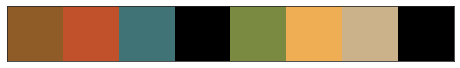

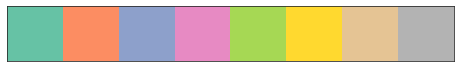

In [24]:
pal_70s = [np.array([143,91,38])/255.0, 
           np.array([193,81,42])/255.0,
           np.array([64,115,117])/255.0,
           np.array([0,0,0])/255.0, 
           np.array([122,138,65])/255.0,
           np.array([239,174,84])/255.0,
           np.array([203,178,139])/255.0,
              np.array([0,0,0])/255.0]
sns.palplot(pal_70s)
pal = sns.color_palette("Set2",n_colors=8)
sns.palplot(pal)
pal = pal_70s

In [25]:
#This is our baseline dictionary which we modify for various conditions. 
#Doing so ensures that we do not inadvertently set a parameter off baseline. 
baseline = dict(name='baseline',
                plot='All',
                num_sims=500,
                data_location = 'data_loc',
                nudge=1, 
                color=np.array([.15,.15,.15]),
                stop_at=np.inf, 
                decay_value=1,
                vcb_value=1, 
                decay_start=np.inf, 
                p_decay=0,
                p_remove = 0,
                freq=5)
#Add removal at various delays
recs = [baseline]
stops = [15,30,60,120,240]
stop_palette = np.array(sns.dark_palette(pal[0], reverse=True, n_colors=len(stops)+1))[1:]
for idx in range(len(stops)):
    add_row = baseline.copy()
    add_row['p_decay'] = 1
    add_row['p_remove'] = 1
    add_row['decay_start'] = stops[idx]
    add_row['stop_at'] = stops[idx]
    add_row['color'] = stop_palette[idx]
    add_row['name'] = 'removal_' + str(stops[idx])
    recs.append(add_row)

#Add probababilistic removal 
for idx in range(len(stops)):
    add_row = baseline.copy()
    add_row['p_decay'] = 1
    add_row['p_remove'] = .2
    add_row['decay_start'] = stops[idx]
    add_row['stop_at'] = stops[idx]
    add_row['color'] = stop_palette[idx]
    add_row['name'] = 'prob_removal_' + str(stops[idx])
    recs.append(add_row)
    
#Add virality circuit breaker applied to all posts
vcb_palette = np.array(sns.dark_palette(pal[-3], reverse=True, n_colors=len(stops)+1))[1:]

for idx in range(len(stops)):
    add_row = baseline.copy()
    add_row['p_decay'] = 1
    add_row['decay_start'] = stops[idx]
    add_row['vcb_value'] = .9
    add_row['color'] = vcb_palette[idx]
    add_row['name'] = 'vcb_' + str(stops[idx])
    recs.append(add_row)
    
#Add virality circuit breaker applied probabalistically 
vcb_palette = np.array(sns.dark_palette(pal[-3], reverse=True, n_colors=len(stops)+1))[1:]
for idx in range(len(stops)):
    add_row = baseline.copy()
    add_row['p_decay'] = .2
    add_row['decay_start'] = stops[idx]
    add_row['vcb_value'] = .9
    add_row['color'] = vcb_palette[idx]
    add_row['name'] = 'prob_vcb_' + str(stops[idx])
    recs.append(add_row)
    
#Add nudges
nudges = [.95,.9,.8,.6]
nudge_palette = sns.dark_palette(pal[2], reverse=False, n_colors=len(nudges)+1)[1:]
for idx in range(len(nudges)):
    add_row = baseline.copy()
    add_row['nudge'] = nudges[idx]
    add_row['color'] = nudge_palette[idx]
    add_row['name'] = 'nudge_' + str(nudges[idx])
    recs.append(add_row)
    


#Add bans
bans=['10K_loc','50K_loc','100K_loc','500K_loc'][::-1]
ban_palette = sns.dark_palette(pal[1], reverse=False, n_colors=len(nudges)+1)[1:]
for idx in range(len(bans)):
    add_row = baseline.copy()
    add_row['data_location'] = bans[idx]
    add_row['color'] = ban_palette[idx]
    add_row['name'] = 'bans_' + str(bans[idx].split('_')[0])
    recs.append(add_row)

bans=['verified_loc','currently_loc']
ban_palette = [np.array([29,161,242])/255.0, pal[6]]
for idx in range(len(bans)):
    add_row = baseline.copy()
    add_row['data_location'] = bans[idx]
    add_row['color'] = ban_palette[idx]
    add_row['name'] = 'bans_' + str(bans[idx].split('_')[0])
    recs.append(add_row)


#Add modest combined simulation
add_row = baseline.copy()
add_row['p_decay'] = .05
add_row['p_remove'] = .2
add_row['decay_start'] = 120
add_row['stop_at'] = 240
add_row['vcb_value'] = .9
add_row['nudge'] = .9
add_row['data_location'] = 'modest_loc'
add_row['color'] = pal[-4]
add_row['name'] = 'modest_0'
recs.append(add_row)

      
    
#Add decay only version of modest policy
add_row = baseline.copy()
add_row['p_decay'] = .05
add_row['p_remove'] = .2
add_row['decay_start'] = 120
add_row['stop_at'] = 240
add_row['vcb_value'] = .9
add_row['color'] = pal[-3]
add_row['name'] = 'modest_decay_only'
recs.append(add_row)


#Add nudge only version of modest policy 
add_row = baseline.copy()
add_row['nudge'] = .9
add_row['color'] = pal[2]
add_row['name'] = 'modest_nudge_only'
recs.append(add_row)

#Add ban only version of modest policy 
add_row = baseline.copy()
add_row['data_location'] = 'modest_loc'
add_row['color'] = pal[1]
add_row['name'] = 'modest_ban_only'
recs.append(add_row)

#Add aggressive combined simulation
add_row = baseline.copy()
add_row['p_decay'] = .10
add_row['p_remove'] = .2
add_row['decay_start'] = 60
add_row['stop_at'] = 120
add_row['vcb_value'] = .8
add_row['nudge'] = .8
add_row['data_location'] = 'aggressive_loc'
add_row['color'] = pal[-4]
add_row['name'] = 'aggressive_0'
recs.append(add_row)


#Add decay only version of aggressive policy
add_row = baseline.copy()
add_row['p_decay'] = .10
add_row['p_remove'] = .2
add_row['decay_start'] = 60
add_row['stop_at'] = 120
add_row['vcb_value'] = .8
add_row['color'] = pal[-3]
add_row['name'] = 'aggressive_decay_only'
recs.append(add_row)

    


#Add nudge only version of aggressive policy 
add_row = baseline.copy()
add_row['nudge'] = .8
add_row['color'] = pal[2]
add_row['name'] = 'aggressive_nudge_only'
recs.append(add_row)



#Add ban only version of aggressive policy 
add_row = baseline.copy()
add_row['data_location'] = 'aggressive_loc'
add_row['color'] = pal[1]
add_row['name'] = 'aggressive_ban_only'
recs.append(add_row)

#Add Combined policy

 
#['aggregated_loc','currently_loc','verified_loc']
   


In [36]:
sim_df = pd.DataFrame.from_records(recs)
from src.simulation import sim_row

#temp = sim_row(sim_df.iloc[0],included)
sim_df.to_csv('./output/simulations/sim_df.csv')
#The keep parameter tells the simulations whether to re-run old simulations (False)
#or keep them. This is very useful if your notebook dies. Just set it to True
#and the simulations will pick up where they left off. 
sim_included = lambda row: sim_row(row, included,verbose=True,keep=False)
_ = sim_df.T.parallel_apply(sim_included)


FileNotFoundError: [Errno 2] No such file or directory: './data/timeseries/aggressive/USPS:_PA_Long_Wait_raw.csv'

In [ ]:
import matplotlib.pyplot as plt
import string
%matplotlib inline

In [ ]:
sim_df = pd.read_csv('./output/simulations/sim_df')

In [ ]:
baseline = pickle.load(open('./output/simulations/baseline.p','rb'))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
xs = np.zeros(included.shape[0])
ys = np.zeros(included.shape[0])
for idx in range(included.shape[0]):
    x=np.median(np.sum(baseline[included.iloc[idx]['event_name']],axis=1))
    ci=np.percentile(np.sum(baseline[included.iloc[idx]['event_name']],axis=1), 
                     q=[5.5,50, 94.5])
    x= ci[1]
    ci= [ci[0], ci[2]]

    y=included.iloc[idx]['observed_engagement']
    plt.scatter(x,y,color='k',alpha=.5,s=5,linewidth=0)
    plt.plot([x,x], [ci[0], ci[1]],alpha=.2, color='k')
    xs[idx] =x 
    ys[idx] = y
plt.plot([0, 1e7],[0, 1e7],ls='--',color='k',alpha=.5)

plt.ylabel('Observed Posts')
plt.xlabel('Simulated Posts')
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylim(1,1e7)
plt.xlim(1,1e7)

plt.tight_layout()
plt.savefig('./output/figures/SI/SimulationValidation.png',dpi=750,transparent=False)

<h2>Figures and Tables</h2>

<h3>Figure 1</h3>

In [ ]:
included.iloc[93]

In [ ]:
print(included.iloc[211])

In [ ]:
sns.set_context('paper',font_scale=1.25)
sns.set_style('white')

#A not quite random event
#If it breaks when you try a random one it's because
#Figure A adds rows before and after the event
#which isn't possible for all events. 
row_loc = 211
row = included.iloc[row_loc]

from src.figures import plot_figure_1
#The code for figure 1 is a bit messy. 
#The simulations and plotting for individual events
#Is a little duct-tapey. 
plot_figure_1(row, included,pal,root='.')
plt.savefig('./output/figures/MS/Fig1.png')

<h3>Figure 2</h3>

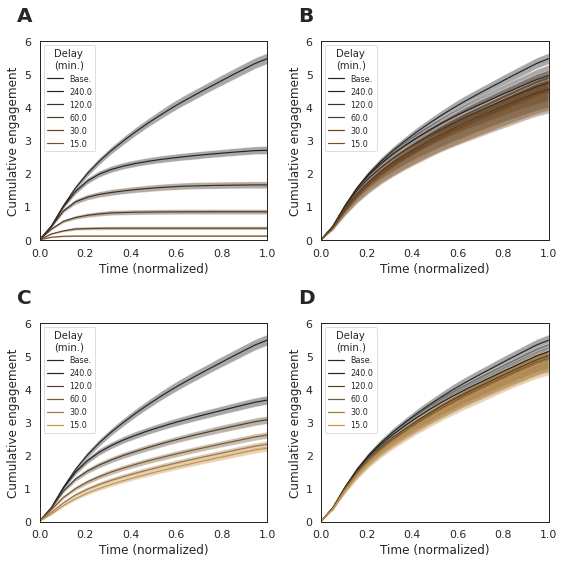

In [39]:
from src.figures import plot_sims
from src.tables import get_table
sns.set_context('paper',font_scale=1.25)
sns.set_style('white')

fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.sca(axs[0])
order = [0,5,4,3,2,1]
table = get_table(sim_df, order)
table.to_latex('./output/tables/full_removal.tex',index=False)

plot_sims(order, sim_df, 'Delay\n(min.)', 'stop_at')

plt.sca(axs[1])
order = [0,10,9,8,7,6]
table = get_table(sim_df, order)
table.to_latex('./output/tables/partial_removal.tex',index=False)

plot_sims(order, sim_df, 'Delay\n(min.)', 'stop_at')

plt.sca(axs[2])
order = [0,15,14,13,12,11]
table = get_table(sim_df, order)
table.to_latex('./output/tables/full_vcb.tex',index=False)

plot_sims(order, sim_df, 'Delay\n(min.)', 'decay_start')

plt.sca(axs[3])
order = [0,20,19,18,17,16]
table = get_table(sim_df, order)
table.to_latex('./output/tables/partial_vcb.tex',index=False)
plot_sims(order, sim_df, 'Delay\n(min.)', 'decay_start')

plt.tight_layout()
plt.savefig('./output/figures/MS/Fig2.png',dpi=1000)

<h3>Figure 3</h3>


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


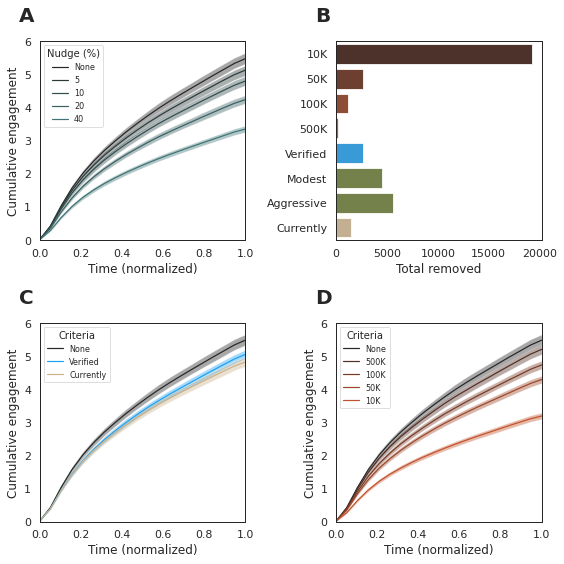

In [40]:
from src.figures import plot_sims
from src.tables import get_table
sns.set_context('paper',font_scale=1.25)
sns.set_style('white')
fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.sca(axs[0])
order = [0,21,22,23,24]

table = get_table(sim_df, order)
table.to_latex('./output/tables/nudge.tex',index=False)

plot_sims(order, sim_df, 'Nudge', 'nudge')
labels = (100-100*sim_df.iloc[order]['nudge'].values).astype('int').tolist()
labels[0] = 'None'
legend = plt.legend(labels=labels,title='Nudge (%)',loc=2,prop={'size': 8})
legend.get_title().set_fontsize('10')

plt.sca(axs[1])
ban_df = pd.read_csv(root + '/data/ban_df_counts.csv')
temp_pal = sns.dark_palette(pal[1], reverse=False, n_colors=len(nudges)+1)[1:]
temp_pal.append( np.array([29,161,242])/255.0)
temp_pal.append(np.array(pal[-4]))
temp_pal.append(pal[-4])
temp_pal.append(pal[6])

sns.barplot(ban_df['Total removed'],
            ban_df['Policy'], palette=temp_pal)
plt.ylabel('')

plt.sca(axs[2])
order = [0,29,30]
table = get_table(sim_df, order)
table.to_latex('./output/tables/ban_current_verified.tex',index=False)

plot_sims(order, sim_df, 'Threshold', 'nudge')
labels = ['Baseline', 'Verified', 'Currently']
labels[0] = 'None'
legend = plt.legend(labels=labels,title='Criteria',loc=2,prop={'size': 8})
legend.get_title().set_fontsize('10')


plt.sca(axs[3])
order = [0,25,26,27,28]
table = get_table(sim_df, order)
table.to_latex('./output/tables/ban_threshold.tex',index=False)

plot_sims(order, sim_df, 'Threshold', 'nudge')
labels = ['Base', '500K', '100K', '50K', '10K']
labels[0] = 'None'
legend = plt.legend(labels=labels,title='Criteria',loc=2,prop={'size': 8})
legend.get_title().set_fontsize('10')

plt.tight_layout()
plt.savefig('./output/figures/MS/Fig3.png',dpi=1000)

<h2> Total reduction in engagment </h2>

In [41]:
incidents = pd.read_parquet('./data/incidents.parquet')
events = pd.read_parquet('./data/events_fitted.parquet')

In [42]:
import src.adjustment as srcadj
max_events_incidents = srcadj.get_adjusted_df(events,incidents)
srcadj.print_engagment(max_events_incidents)

Total engagement
12915376.0
Before Engagement Total, Percent
1547731.0
11.98
During Engagement Total, Percent
5150993.0
39.88
After Engagement Total, Percent
6216652.0
48.13


In [43]:
neg_binom_glm = pystan.StanModel(file='./src/neg_binom.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bcb3372f83e3dafe0adb2f026e6c7f1d NOW.


In [44]:
neg_binom_samples,x_sim = srcadj.sample_neg_binom(neg_binom_glm, max_events_incidents)
print(pystan.stansummary(neg_binom_samples,pars=['beta','sigma']))

Inference for Stan model: anon_model_bcb3372f83e3dafe0adb2f026e6c7f1d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta    0.94  2.2e-4   0.01   0.92   0.94   0.94   0.95   0.97   3407    1.0
sigma   1.43  1.6e-3   0.09   1.26   1.37   1.43   1.49   1.62   3093    1.0

Samples were drawn using NUTS at Fri Apr 23 16:56:44 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [45]:
ci_beta = np.percentile(neg_binom_samples['beta'], q=[5.5,50,94.5])
ci_sigma = np.percentile(neg_binom_samples['beta'], q=[5.5,50,94.5])
outrows = []

for name in ['beta','sigma']:
    ci = np.percentile(neg_binom_samples[name], q=[5.5,50,94.5])
    print(ci)
    outrows.append({'name':name,
     '$\mu (\% change)$':ci[1], 
     '5.5\%':str(np.round(ci[0],2)),
     '94.5\%':str(np.round(ci[2],2))})
pd.DataFrame(outrows).to_latex('./output/tables/LogNormalRegression.tex',index=False)

[0.92451207 0.94463994 0.96554961]
[1.2974198  1.42652956 1.58119325]


,name,$\mu (\% change)$,5.5\%,94.5\%
0,beta,0.94464,0.92,0.97
1,sigma,1.42653,1.3,1.58


In [46]:
import src.adjustment as srcadj
order = [0,36,37,38,35]

plot_dfs,colors = srcadj.get_plot_df(order,max_events_incidents, sim_df, neg_binom_samples)

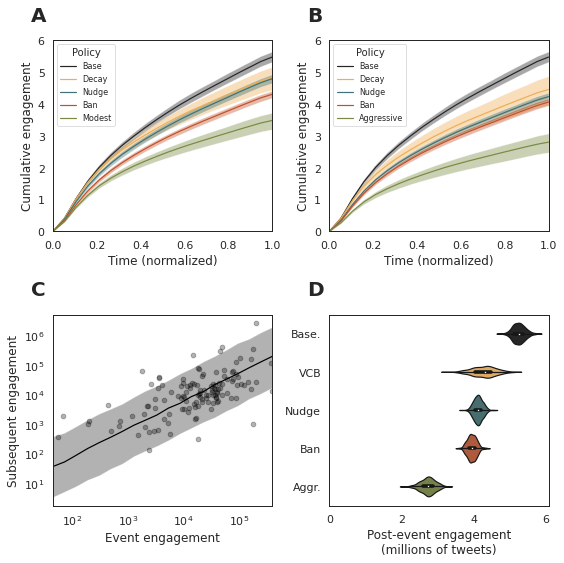

In [48]:
import seaborn as sns
from src.figures import plot4c

fig, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flat

for n, ax in enumerate(axs):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')
    
plt.sca(axs[0])   
order = [0,32,33,34,31]
table = get_table(sim_df, order)
table.to_latex('./output/tables/modest.tex',index=False)

plot_sims(order, sim_df, 'Threshold', 'nudge')
labels = ['Base','Decay', 'Nudge', 'Ban', 'Modest' ] #Double check label ordering
legend = plt.legend(labels=labels,title='Policy',loc=2,prop={'size': 8})
legend.get_title().set_fontsize('10')

plt.sca(axs[1])   
order = [0,36,37,38,35]
table = get_table(sim_df, order)
table.to_latex('./output/tables/aggressive.tex',index=False)

plot_sims(order, sim_df, 'Threshold', 'nudge')
labels = ['Base','Decay', 'Nudge', 'Ban', 'Aggressive' ]
legend = plt.legend(labels=labels,title='Policy',loc=2,prop={'size': 8})
legend.get_title().set_fontsize('10')

#Define some values to simulate in generated quantities block
x_sim = np.logspace(np.log(np.min(max_events_incidents['observed_engagement'])-10),
                np.log(np.max(max_events_incidents['observed_engagement'])+20),20,base=np.e)
plt.sca(axs[2])
plot4c(neg_binom_samples, max_events_incidents,x_sim)

plt.sca(axs[3])
sns.violinplot(y='name', x='total_adjusted',data=plot_dfs,palette=colors)
plt.xlabel('Post-event engagement\n(millions of tweets)')
plt.ylabel(None)
plt.xlim(0,)
plt.tight_layout()
plt.savefig('./output/figures/MS/Fig4.png',dpi=1000)

In [49]:
order = [0,32,33,34,31]
table = get_table(sim_df, order)
plot_dfs_modest,colors_modest = srcadj.get_plot_df(order,max_events_incidents, sim_df, neg_binom_samples)

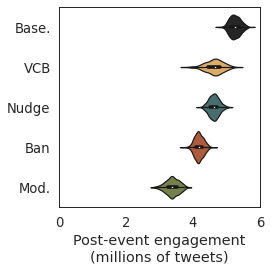

In [50]:
sns.set_style('white')
sns.set_context('paper',font_scale=1.5)
plt.figure(figsize=(4,4))
sns.violinplot(y='name', x='total_adjusted',data=plot_dfs_modest,palette=colors)
plt.xlabel('Post-event engagement\n(millions of tweets)')
plt.ylabel(None)
plt.xlim(0,)
plt.tight_layout()
plt.savefig('./output/figures/SI/SIModest.png',dpi=1000)